In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.nn.functional import relu, binary_cross_entropy, mse_loss
import torchvision
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage
#from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor
from tqdm.notebook import tqdm
from tensorboardX import SummaryWriter
from torchinfo import summary
from PIL import Image

# Import des données CIFAR10

In [2]:
trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=ToTensor())
testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [3]:
data_train = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
data_test = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

In [4]:
classes = trainset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

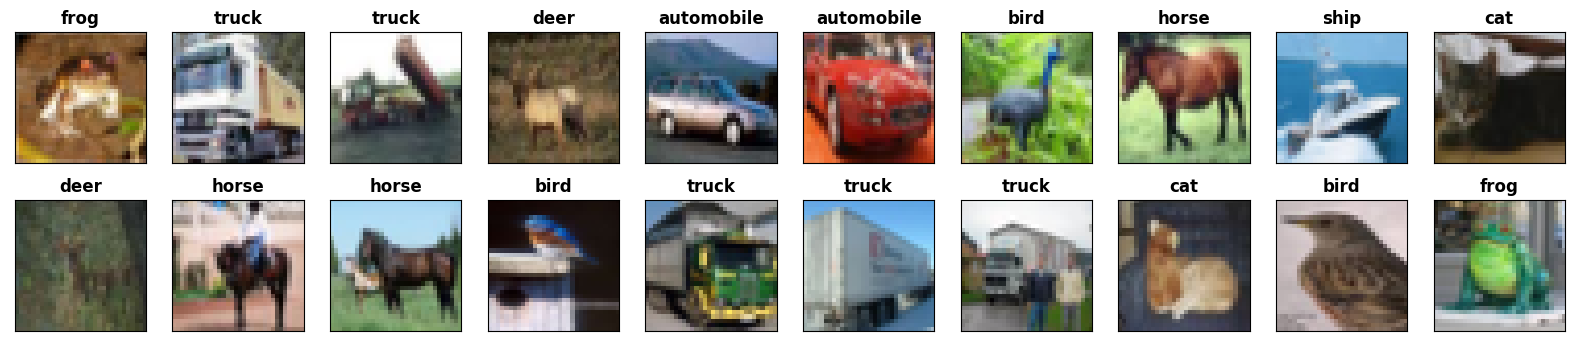

In [5]:
plt.figure(figsize=(20, 4))
number = 10
for i in range(number):
    ax = plt.subplot(2, number, i + 1)
    plt.imshow(trainset[i][0].view(3, 32, 32).permute(1,2,0))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"{classes[trainset[i][1]]}", fontweight="bold")
    ax = plt.subplot(2, number, i + 1 + number)
    plt.imshow(trainset[i + number][0].view(3, 32, 32).permute(1,2,0))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"{classes[trainset[i + number][1]]}", fontweight="bold")
plt.show()

In [6]:
trainset[0][0].shape

torch.Size([3, 32, 32])

In [7]:
len(trainset)

50000

# VAE

Le générateur d'un GAN est en fait le même modèle que le décodeur d'un VAE. Je teste donc un VAE sur CIFAR pour voir la structure qui marche le mieux pour le décodeur, et reprendre la même pour mon générateur. <br>
Après tests d'implémentation en linear (i.e. sans CNN), les résultats ne sont pas bons. Je teste donc avec des layers de convolution

Pour rappel, avec le reparametrization trick, $z = \mu + \sigma \epsilon$ avec $\epsilon \sim \mathcal{N}(0, 1)$

In [8]:
class VAE(torch.nn.Module):
    def __init__(self, z_dim=512):
        """ Constructeur du VAE
            Initialise les couches du réseau et leurs paramètres
        """
        super(VAE, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(3, 12, 4, stride=2, padding=1)           # [batch, 12, 16, 16]
        self.conv2 = torch.nn.Conv2d(12, 24, 4, stride=2, padding=1)          # [batch, 24, 8, 8]
        self.conv3 = torch.nn.Conv2d(24, 48, 4, stride=2, padding=1)          # [batch, 48, 4, 4]
        self.fc1 = torch.nn.Linear(48*4*4, z_dim)
        self.fc2 = torch.nn.Linear(48*4*4, z_dim)
        self.fc3 = torch.nn.Linear(z_dim, 48*4*4)
        self.conv4 = torch.nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1) # [batch, 24, 8, 8]
        self.conv5 = torch.nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1) # [batch, 12, 16, 16]
        self.conv6 = torch.nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1)  # [batch, 3, 32, 32]
        
        
    def encode(self, x):
        """ Encode un batch d'images
            Args:
                x (tensor torch, dim(batch_size x 3x32x32)) : batch d'images
            Output:
                mu (tensor torch, dim(batch_size x z_dim)) : moyennes des distributions apprises
                logvar (tensor torch, dim(batch_size x z_dim)) : log de la variance des distributions apprises
        """
        h1 = relu(self.conv1(x))
        h2 = relu(self.conv2(h1))
        h3 = relu(self.conv3(h2))
        h3 = h3.view(-1, 48*4*4)
        return self.fc1(h3), self.fc2(h3)

    
    def sample(self, mu, logvar):
        """ Echantillonne un vecteur latent à partir des mu et sigma générés par l'encodeur
            Args:
                mu (tensor torch, dim(batch_size x z_dim)) : moyennes des distributions apprises
                logvar (tensor torch, dim(batch_size x z_dim)) : log de la variance des distributions apprises
            Output:
                z (tensor torch, dim(batch_size x z_dim)) : batchs de vecteurs latents
        """
        std = torch.exp(0.5*logvar) # 0.5 pour prendre la racine, exp pour neutraliser le log
        epsilon = torch.randn_like(std) # randn_like : sample from N(0,1) pour tensor de dim std
        return mu  + std * epsilon
    
    
    def decode(self, z):
        """ Génère une image à partir d'un batch de vecteurs latents
            Args:
                z (tensor torch, dim(batch_size x z_dim)) : batchs de vecteurs latents
            Output:
                x_prime (tensor torch, dim(batch_size x 3x32x32)) : batch d'images générées
        """
        h4 = relu(self.fc3(z))
        h4 = h4.view(-1, 48, 4, 4)
        h5 = relu(self.conv4(h4))
        h6 = relu(self.conv5(h5))
        return torch.sigmoid(self.conv6(h6))
    
    
    def forward(self, x):
        """ Génère un batch d'images à partir d'un batch d'images initiales
            Args:
                x (tensor torch, dim(batch_size x 3x32x32)) : batch d'images initiales
            Output:
                x_prime (tensor torch, dim(batch_size x 3x32x32)) : batch d'images générées
                mu (tensor torch, dim(batch_size x z_dim)) : moyennes des distributions apprises
                logvar (tensor torch, dim(batch_size x z_dim)) : log de la variance des distributions apprises
        """
        mu, logvar = self.encode(x)
        z = self.sample(mu, logvar)
        return self.decode(z), mu, logvar
    
    
    def compute_loss(self, x, x_prime, mu, logvar):
        """ Calcule la fonction de perte pour une itération
            Args:
                x (tensor torch, dim(batch_size x 3x32x32)) : batch d'images initiales
                x_tilde (tensor torch, dim(batch_size x 3x32x32)) : batch d'images générées
                mu (tensor torch, dim(batch_size x z_dim)) : moyennes des distributions apprises
                logvar (tensor torch, dim(batch_size x z_dim)) : log de la variance des distributions app
            Output:
                loss (float) : valeur de la perte
        """
        cross_entropy = binary_cross_entropy(x_prime, x, reduction='sum')
        divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return cross_entropy + divergence
        
    
    def train_model(self, data, epoch, optim):
        """ Entraîne le modèle sur un batch d'images d'entraînement
            Args:
                data (tensor torch, dim(dataset_size x 3x32x32)) : jeu complet d'images initiales (en batchs)
                epoch : nombre d'itérations à réaliser sur le jeu d'entraînement complet
        """
        losses = []
        for e in tqdm(range(epoch)):
            train_loss = 0
            for batch in data:
                x = batch[0].to(torch.device("cuda"))
                optim.zero_grad()
                x_prime, mu, logvar = self.forward(x)
                loss = self.compute_loss(x, x_prime, mu, logvar)
                train_loss += loss.item()
                loss.backward()
                optim.step()
            print(f"{datetime.now().strftime('%H:%M:%S')} : Epoch {e} - Average loss {train_loss/len(data):.0f}")
            losses.append(train_loss/len(data))
        return losses

In [9]:
vae = VAE().to(torch.device("cuda"))

In [10]:
summary(vae)

Layer (type:depth-idx)                   Param #
VAE                                      --
├─Conv2d: 1-1                            588
├─Conv2d: 1-2                            4,632
├─Conv2d: 1-3                            18,480
├─Linear: 1-4                            393,728
├─Linear: 1-5                            393,728
├─Linear: 1-6                            393,984
├─ConvTranspose2d: 1-7                   18,456
├─ConvTranspose2d: 1-8                   4,620
├─ConvTranspose2d: 1-9                   579
Total params: 1,228,795
Trainable params: 1,228,795
Non-trainable params: 0

100 itérations

In [11]:
vae = VAE().to(torch.device("cuda"))
optim_vae = torch.optim.Adam(vae.parameters())
losses = vae.train_model(data_train, 100, optim_vae)

  0%|          | 0/100 [00:00<?, ?it/s]

23:31:54 : Epoch 0 - Average loss 62740
23:32:06 : Epoch 1 - Average loss 60129
23:32:18 : Epoch 2 - Average loss 59360
23:32:30 : Epoch 3 - Average loss 59047
23:32:40 : Epoch 4 - Average loss 58870
23:32:52 : Epoch 5 - Average loss 58766
23:33:04 : Epoch 6 - Average loss 58710
23:33:15 : Epoch 7 - Average loss 58657
23:33:27 : Epoch 8 - Average loss 58621
23:33:38 : Epoch 9 - Average loss 58590
23:33:49 : Epoch 10 - Average loss 58558
23:34:00 : Epoch 11 - Average loss 58529
23:34:11 : Epoch 12 - Average loss 58508
23:34:22 : Epoch 13 - Average loss 58487
23:34:33 : Epoch 14 - Average loss 58466
23:34:45 : Epoch 15 - Average loss 58447
23:34:56 : Epoch 16 - Average loss 58432
23:35:06 : Epoch 17 - Average loss 58420
23:35:17 : Epoch 18 - Average loss 58412
23:35:28 : Epoch 19 - Average loss 58400
23:35:39 : Epoch 20 - Average loss 58394
23:35:49 : Epoch 21 - Average loss 58387
23:36:00 : Epoch 22 - Average loss 58378
23:36:11 : Epoch 23 - Average loss 58369
23:36:22 : Epoch 24 - Aver

In [12]:
pred_train = [vae.forward(trainset[i][0].to(torch.device("cuda"))) for i in range(11)]
pred_test = [vae.forward(testset[i][0].to(torch.device("cuda"))) for i in range(11)]

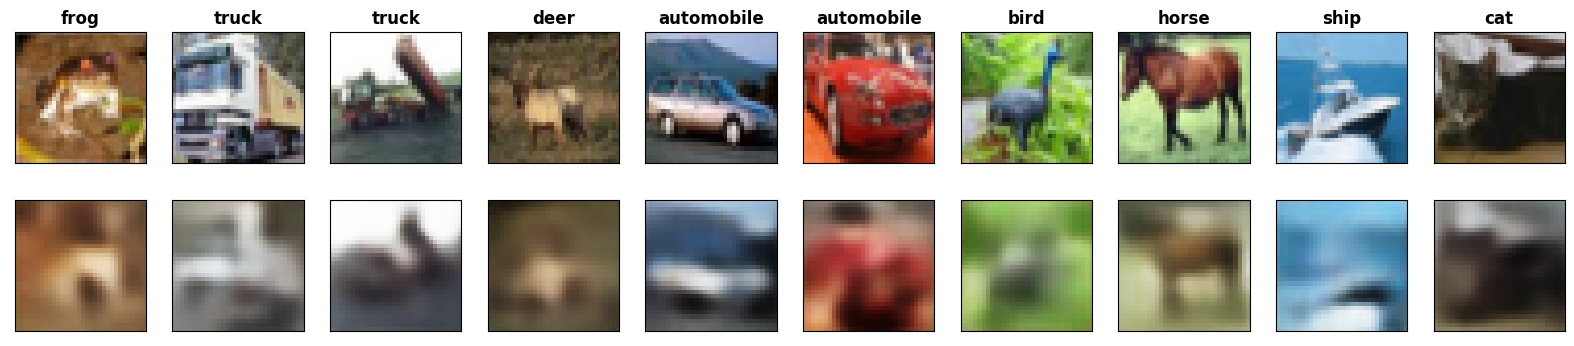

In [13]:
plt.figure(figsize=(20, 4))
number = 10
for i in range(number):
    ax = plt.subplot(2, number, i + 1)
    plt.imshow(trainset[i][0].view(3, 32, 32).permute(1,2,0))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"{classes[trainset[i][1]]}", fontweight="bold")
    ax = plt.subplot(2, number, i + 1 + number)
    plt.imshow(pred_train[i][0].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

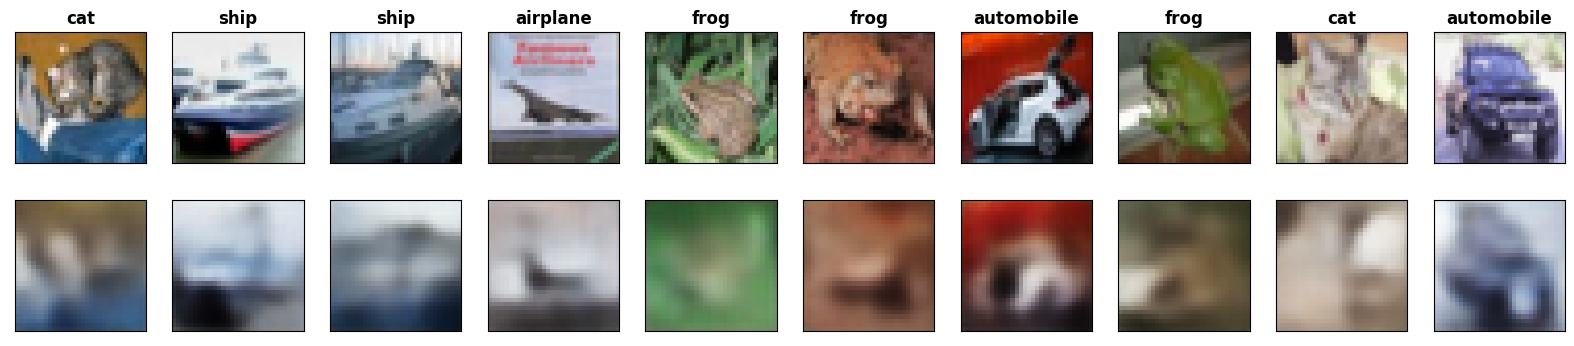

In [14]:
plt.figure(figsize=(20, 4))
number = 10
for i in range(number):
    ax = plt.subplot(2, number, i + 1)
    plt.imshow(testset[i][0].view(3, 32, 32).permute(1,2,0))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"{classes[testset[i][1]]}", fontweight="bold")
    ax = plt.subplot(2, number, i + 1 + number)
    plt.imshow(pred_test[i][0].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Images floues, même après 50 itérations. Test avec même archi, mais encodeur standard

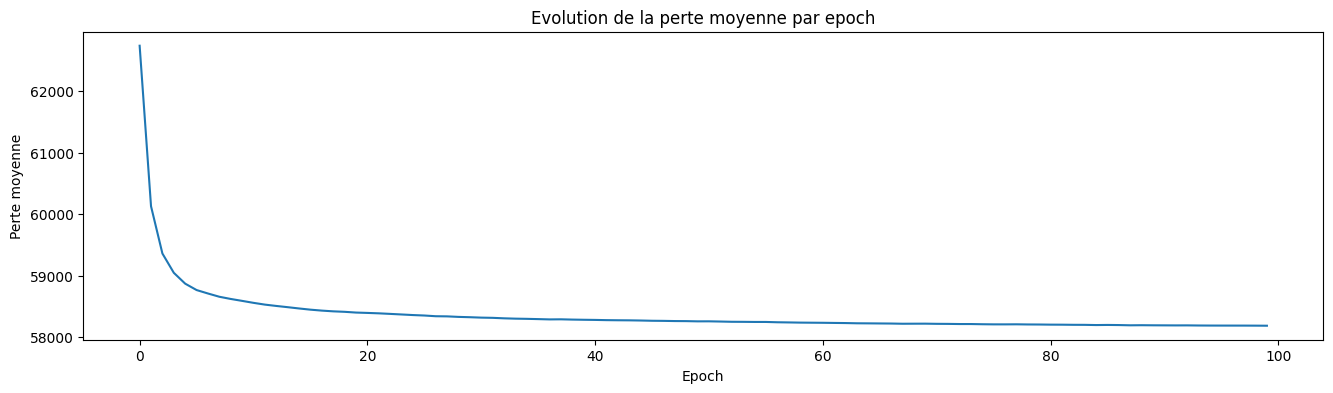

In [15]:
plt.figure(figsize=(16, 4))
plt.plot(np.arange(100), losses)
plt.xlabel("Epoch")
plt.ylabel("Perte moyenne")
plt.title("Evolution de la perte moyenne par epoch")
plt.show()

# Autoencodeur standard

In [16]:
class Autoencodeur(torch.nn.Module):
    def __init__(self, z_dim=512):
        """ Constructeur du VAE
            Initialise les couches du réseau et leurs paramètres
        """
        super(Autoencodeur, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(3, 12, 4, stride=2, padding=1)           # [batch, 12, 16, 16]
        self.conv2 = torch.nn.Conv2d(12, 24, 4, stride=2, padding=1)          # [batch, 24, 8, 8]
        self.conv3 = torch.nn.Conv2d(24, 48, 4, stride=2, padding=1)          # [batch, 48, 4, 4]
        self.fc1 = torch.nn.Linear(48*4*4, z_dim)
        self.fc2 = torch.nn.Linear(z_dim, 48*4*4)
        self.conv4 = torch.nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1) # [batch, 24, 8, 8]
        self.conv5 = torch.nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1) # [batch, 12, 16, 16]
        self.conv6 = torch.nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1)  # [batch, 3, 32, 32]
        
        
    def encode(self, x):
        """ Encode un batch d'images
            Args:
                x (tensor torch, dim(batch_size x 3x32x32)) : batch d'images
            Output:
                z (tensor torch, dim(batch_size x z_dim)) : batch de vecteurs latents
        """
        h1 = relu(self.conv1(x))
        h2 = relu(self.conv2(h1))
        h3 = relu(self.conv3(h2))
        h3 = h3.view(-1, 48*4*4)
        return self.fc1(h3)
  
    
    def decode(self, z):
        """ Génère une image à partir d'un batch de vecteurs latents
            Args:
                z (tensor torch, dim(batch_size x z_dim)) : batchs de vecteurs latents
            Output:
                x_prime (tensor torch, dim(batch_size x 3x32x32)) : batch d'images générées
        """
        h4 = relu(self.fc2(z))
        h4 = h4.view(-1, 48, 4, 4)
        h5 = relu(self.conv4(h4))
        h6 = relu(self.conv5(h5))
        return torch.sigmoid(self.conv6(h6))
    
    
    def forward(self, x):
        """ Génère un batch d'images à partir d'un batch d'images initiales
            Args:
                x (tensor torch, dim(batch_size x 3x32x32)) : batch d'images initiales
            Output:
                x_prime (tensor torch, dim(batch_size x 3x32x32)) : batch d'images générées
        """
        z = self.encode(x)
        return self.decode(z)
    
    
    def compute_loss(self, x, x_prime):
        """ Calcule la fonction de perte pour une itération
            Args:
                x (tensor torch, dim(batch_size x 3x32x32)) : batch d'images initiales
                x_tilde (tensor torch, dim(batch_size x 3x32x32)) : batch d'images générées
            Output:
                loss (float) : valeur de la perte
        """
        return binary_cross_entropy(x_prime, x, reduction='sum')
        
    
    def train_model(self, data, epoch, optim):
        """ Entraîne le modèle sur un batch d'images d'entraînement
            Args:
                data (tensor torch, dim(dataset_size x 3x32x32)) : jeu complet d'images initiales (en batchs)
                epoch : nombre d'itérations à réaliser sur le jeu d'entraînement complet
        """
        losses = []
        for e in tqdm(range(epoch)):
            train_loss = 0
            for batch in data:
                x = batch[0].to(torch.device("cuda"))
                optim.zero_grad()
                x_prime = self.forward(x)
                loss = self.compute_loss(x, x_prime)
                train_loss += loss.item()
                loss.backward()
                optim.step()
            print(f"{datetime.now().strftime('%H:%M:%S')} : Epoch {e} - Average loss {train_loss/len(data):.0f}")
            losses.append(train_loss/len(data))
        return losses

In [17]:
ae = Autoencodeur().to(torch.device("cuda"))
optim_ae = torch.optim.Adam(ae.parameters())
losses = ae.train_model(data_train, 100, optim_ae)

  0%|          | 0/100 [00:00<?, ?it/s]

23:50:17 : Epoch 0 - Average loss 58184
23:50:27 : Epoch 1 - Average loss 56262
23:50:37 : Epoch 2 - Average loss 55844
23:50:47 : Epoch 3 - Average loss 55506
23:50:57 : Epoch 4 - Average loss 55305
23:51:07 : Epoch 5 - Average loss 55153
23:51:17 : Epoch 6 - Average loss 55046
23:51:27 : Epoch 7 - Average loss 54963
23:51:37 : Epoch 8 - Average loss 54894
23:51:47 : Epoch 9 - Average loss 54839
23:51:57 : Epoch 10 - Average loss 54784
23:52:07 : Epoch 11 - Average loss 54748
23:52:17 : Epoch 12 - Average loss 54703
23:52:27 : Epoch 13 - Average loss 54671
23:52:37 : Epoch 14 - Average loss 54639
23:52:47 : Epoch 15 - Average loss 54611
23:52:57 : Epoch 16 - Average loss 54604
23:53:07 : Epoch 17 - Average loss 54581
23:53:17 : Epoch 18 - Average loss 54551
23:53:27 : Epoch 19 - Average loss 54534
23:53:37 : Epoch 20 - Average loss 54515
23:53:47 : Epoch 21 - Average loss 54501
23:53:57 : Epoch 22 - Average loss 54488
23:54:07 : Epoch 23 - Average loss 54474
23:54:17 : Epoch 24 - Aver

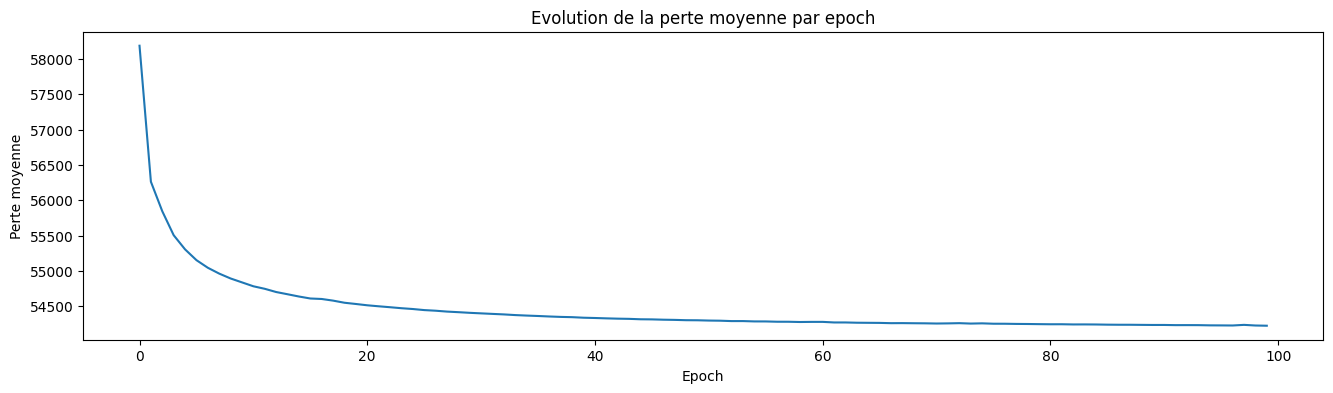

In [18]:
plt.figure(figsize=(16, 4))
plt.plot(np.arange(100), losses)
plt.xlabel("Epoch")
plt.ylabel("Perte moyenne")
plt.title("Evolution de la perte moyenne par epoch")
plt.show()

In [19]:
pred_train = [ae.forward(trainset[i][0].to(torch.device("cuda"))) for i in range(11)]
pred_test = [ae.forward(testset[i][0].to(torch.device("cuda"))) for i in range(11)]

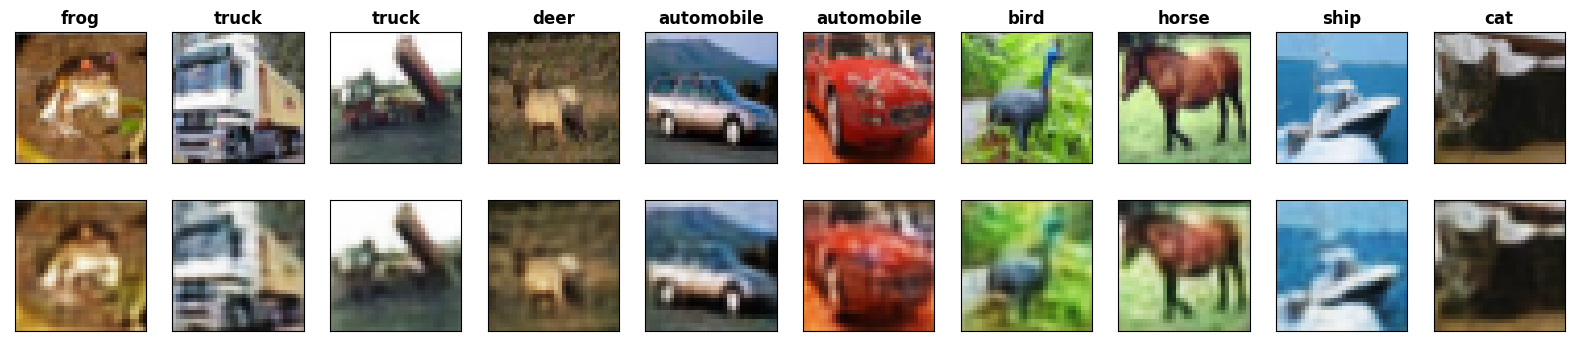

In [20]:
plt.figure(figsize=(20, 4))
number = 10
for i in range(number):
    ax = plt.subplot(2, number, i + 1)
    plt.imshow(trainset[i][0].view(3, 32, 32).permute(1,2,0))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"{classes[trainset[i][1]]}", fontweight="bold")
    ax = plt.subplot(2, number, i + 1 + number)
    plt.imshow(pred_train[i].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

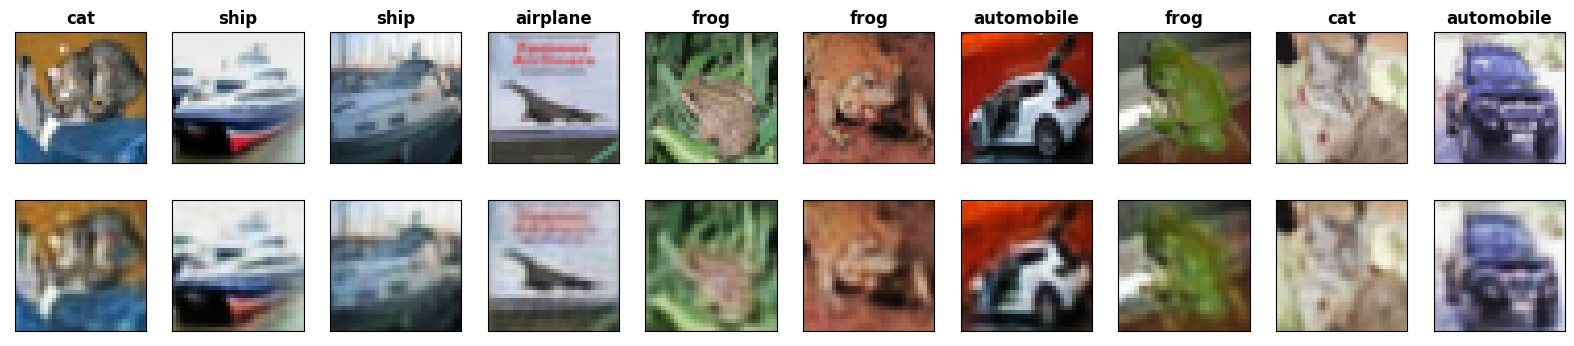

In [21]:
plt.figure(figsize=(20, 4))
number = 10
for i in range(number):
    ax = plt.subplot(2, number, i + 1)
    plt.imshow(testset[i][0].view(3, 32, 32).permute(1,2,0))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"{classes[testset[i][1]]}", fontweight="bold")
    ax = plt.subplot(2, number, i + 1 + number)
    plt.imshow(pred_test[i].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Images reconstruites sont plutôt fidèles -> fait apparaître de manière évidente le flou introduit par la méthode stochastique des VAE <br>
Comparaison des images reconstuites (haut VAE, bas autoencodeur standard)

In [22]:
ae_train = [ae.forward(trainset[i][0].to(torch.device("cuda"))) for i in range(11)]
vae_train = [vae.forward(trainset[i][0].to(torch.device("cuda"))) for i in range(11)]

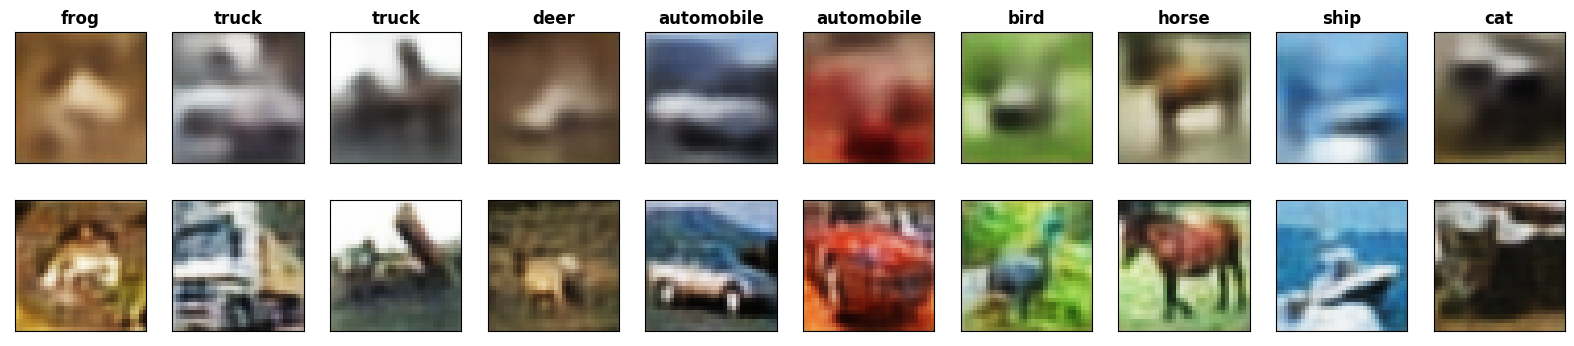

In [23]:
plt.figure(figsize=(20, 4))
number = 10
for i in range(number):
    ax = plt.subplot(2, number, i + 1)
    plt.imshow(vae_train[i][0].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"{classes[trainset[i][1]]}", fontweight="bold")
    ax = plt.subplot(2, number, i + 1 + number)
    plt.imshow(ae_train[i].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [24]:
torch.save({'epoch': 100, 'model_state_dict': ae.state_dict(),
            'optimizer_state_dict': optim_ae.state_dict()}, "models/autoencoder_cifar10.pt")
torch.save({'epoch': 100, 'model_state_dict': vae.state_dict(),
            'optimizer_state_dict': optim_vae.state_dict()}, "models/vae_cifar10.pt")

In [ ]:
# # Load model
# model = VAE().to(torch.device("cuda"))
# checkpoint = torch.load("models/vae_cifar10.pt")
# model.load_state_dict(checkpoint['model_state_dict'])
# model_train = [model.forward(trainset[i][0].to(torch.device("cuda"))) for i in range(11)]

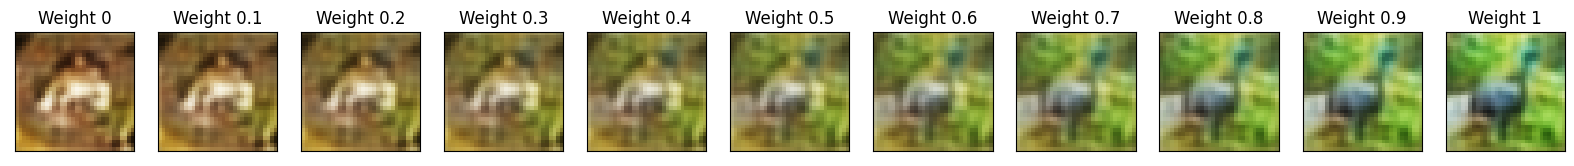

In [25]:
frog_embedding = ae.encode(trainset[0][0].to(torch.device("cuda")))
bird_embedding = ae.encode(trainset[6][0].to(torch.device("cuda")))
plt.figure(figsize=(20, 4))
for i, w in enumerate([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]):
    embedding = (1-w) * frog_embedding + w * bird_embedding
    ax = plt.subplot(1, 11, i+1)
    plt.imshow(ae.decode(embedding).view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"Weight {w}")
plt.show()

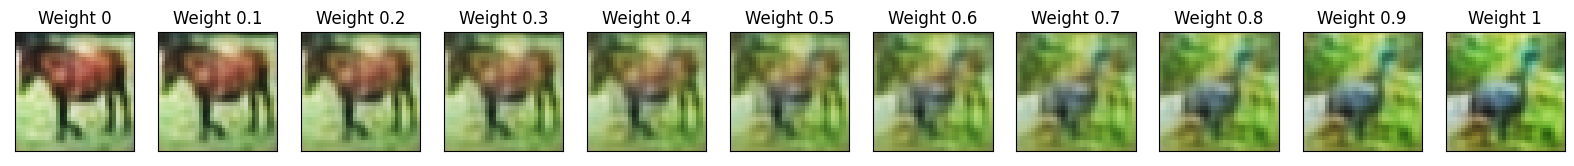

In [27]:
horse_embedding = ae.encode(trainset[7][0].to(torch.device("cuda")))
bird_embedding = ae.encode(trainset[6][0].to(torch.device("cuda")))
plt.figure(figsize=(20, 4))
for i, w in enumerate([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]):
    embedding = (1-w) * horse_embedding + w * bird_embedding
    ax = plt.subplot(1, 11, i+1)
    plt.imshow(ae.decode(embedding).view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"Weight {w}")
plt.show()

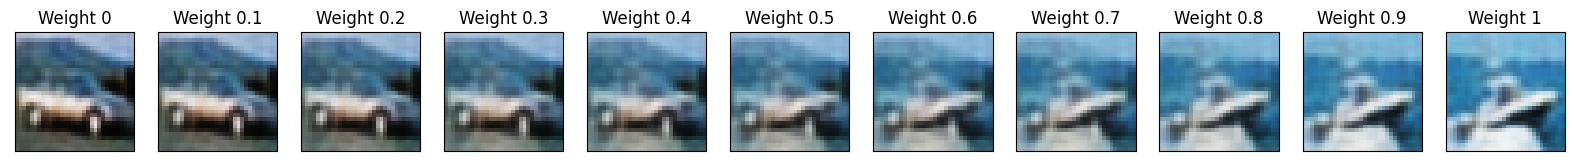

In [31]:
auto_embedding = ae.encode(trainset[4][0].to(torch.device("cuda")))
ship_embedding = ae.encode(trainset[8][0].to(torch.device("cuda")))
plt.figure(figsize=(20, 4))
for i, w in enumerate([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]):
    embedding = (1-w) * auto_embedding + w * ship_embedding
    ax = plt.subplot(1, 11, i+1)
    plt.imshow(ae.decode(embedding).view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"Weight {w}")
plt.show()

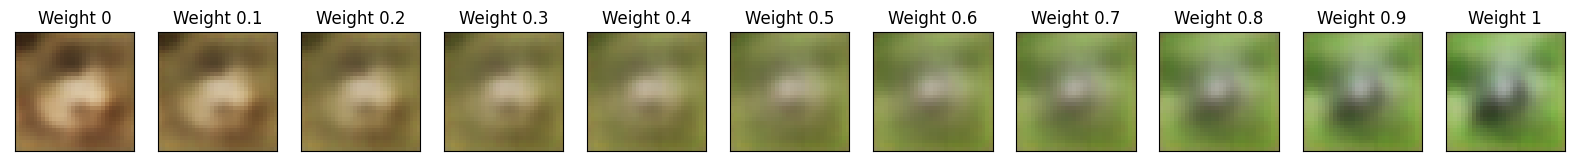

In [26]:
mu_frog, logvar_frog = vae.encode(trainset[0][0].to(torch.device("cuda")))
frog_embedding = vae.sample(mu_frog, logvar_frog)
mu_bird, logvar_bird = vae.encode(trainset[6][0].to(torch.device("cuda")))
bird_embedding = vae.sample(mu_bird, logvar_bird)
plt.figure(figsize=(20, 4))
for i, w in enumerate([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]):
    embedding = (1-w) * frog_embedding + w * bird_embedding
    ax = plt.subplot(1, 11, i+1)
    plt.imshow(vae.decode(embedding).view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"Weight {w}")
plt.show()

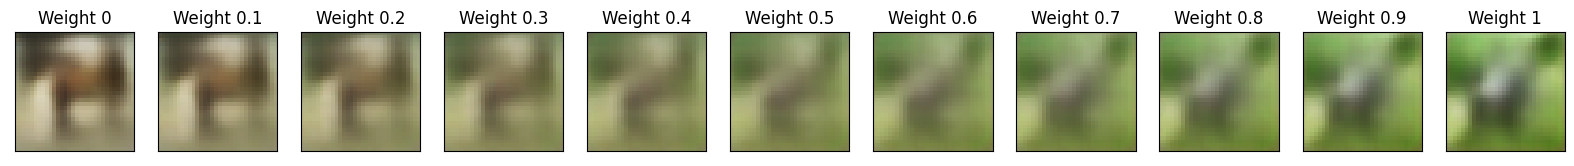

In [30]:
mu_horse, logvar_horse = vae.encode(trainset[7][0].to(torch.device("cuda")))
horse_embedding = vae.sample(mu_horse, logvar_horse)
mu_bird, logvar_bird = vae.encode(trainset[6][0].to(torch.device("cuda")))
bird_embedding = vae.sample(mu_bird, logvar_bird)
plt.figure(figsize=(20, 4))
for i, w in enumerate([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]):
    embedding = (1-w) * horse_embedding + w * bird_embedding
    ax = plt.subplot(1, 11, i+1)
    plt.imshow(vae.decode(embedding).view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"Weight {w}")
plt.show()

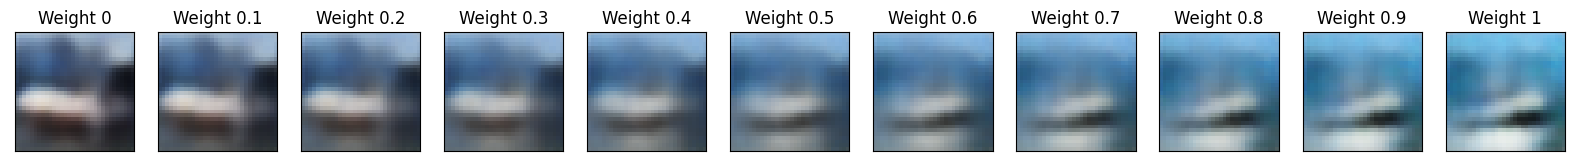

In [32]:
mu_auto, logvar_auto = vae.encode(trainset[4][0].to(torch.device("cuda")))
auto_embedding = vae.sample(mu_auto, logvar_auto)
mu_ship, logvar_ship = vae.encode(trainset[8][0].to(torch.device("cuda")))
ship_embedding = vae.sample(mu_ship, logvar_ship)
plt.figure(figsize=(20, 4))
for i, w in enumerate([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]):
    embedding = (1-w) * auto_embedding + w * ship_embedding
    ax = plt.subplot(1, 11, i+1)
    plt.imshow(vae.decode(embedding).view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"Weight {w}")
plt.show()

# GAN implementation

## Fréchet Inception Distance (FID)

Calcule la distance de Fréchet entre les embeddings de 2 distributions. Les embeddings des distributions sont créés à partir du modèle Inception v3.

In [18]:
# # https://towardsdatascience.com/assessing-similarity-between-two-images-groups-using-inception-v3-and-fid-score-4b0367a74e67
# # Chargement du modèle préentrainé
# inception = torchvision.models.inception_v3(weights='DEFAULT').cuda()
# inception.eval()
# # Génération d'un graphe des couches du modèle
# train_nodes, eval_nodes = get_graph_node_names(inception)
# # Extrait toutes les couches sauf la dernière
# features_inception = create_feature_extractor(inception, return_nodes=eval_nodes[:-1]).cuda()

In [6]:
# https://minibatchai.com/metrics/generative-models/2022/07/23/FID.html
inception = torchvision.models.inception_v3(weights='DEFAULT').cuda()
# Hack to get features 
inception.fc = torch.nn.Identity()
inception.eval();

Les images doivent être de dimension 299 $\times$ 299 px. Il faut donc les redimensionner pour créer les embeddings Inception... Plusieurs solutions : padding blanc autour des images, scitkit-image pour scale les images, ... <br>
Je vais resize avec PIL, qui a l'air d'être la seule lib qui le fasse bien d'après cet article : https://github.com/GaParmar/clean-fid -> test avec PIL Bicubic

In [26]:
# Dans son code, le mode 'F' est utilisé pour convertir les array en images PIL 
# F = 32-bit floating point pixels (cf. https://pillow.readthedocs.io/en/stable/handbook/concepts.html)
PILset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True,
                                      transform=Compose([ToTensor(),ToPILImage(mode='F')]))

Files already downloaded and verified


In [27]:
# Non compatible avec le mode F, qui n'est disponible que pour 1 channel (pas 3 d'un coup)
# type(PILset[0][0])
# Returns ValueError: Only modes ['RGB', 'YCbCr', 'HSV'] are supported for 3D inputs

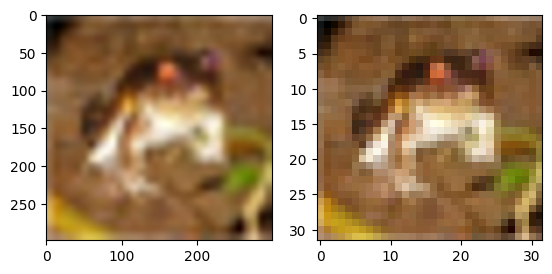

In [7]:
# Test de resize sur 1 image
tensor = []
for channel in trainset[0][0]:
    img = ToPILImage(mode='F')(channel)
    tensor.append(ToTensor()(img.resize((299, 299), resample=Image.BICUBIC)))
tensor3d = torch.clamp(torch.cat(tensor,0), 0, 1)
plt.subplot(1,2,1)
plt.imshow(tensor3d.permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(trainset[0][0].permute(1,2,0))
plt.show()

In [7]:
def resize_batch(data):
    resized_batch = []
    for i, _ in enumerate(data):
        tensor = []
        for channel in data[i]:
            img = ToPILImage(mode='F')(channel)
            tensor.append(ToTensor()(img.resize((299, 299), resample=Image.BICUBIC)))
        resized_batch.append(torch.clamp(torch.cat(tensor,0), 0, 1))
    return resized_batch

In [ ]:
# Resize de toutes les images d'un batch pour passage dans le modèle Inception
start = datetime.now()
resized_data = []
for data in data_train:
    resized_data.append(torch.stack(resize_batch(data[0])))
    #print(f"Time taken {datetime.now() - start} - {resized_batch[0].shape}")
print(f"Time taken {datetime.now() - start} - {resized_data[0].shape}")

## Test 1

In [8]:
class Generator(torch.nn.Module):
    def __init__(self, z_dim=512):
        super(Generator, self).__init__()
        
        self.fc = torch.nn.Linear(z_dim, 48*4*4)
        self.deConv = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1), # [batch, 24, 8, 8]
            torch.nn.BatchNorm2d(24),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1), # [batch, 12, 16, 16]
            torch.nn.BatchNorm2d(12),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),  # [batch, 3, 32, 32]
            torch.nn.Sigmoid()            
        )

        
    def forward(self, z):
        """ Génère un batch d'images à partir d'un batch de bruits initiaux
            Args:
                z (tensor torch, dim(batch_size x z_dim)) : batch de bruits initiaux
            Output:
                x_prime (tensor torch, dim(batch_size x 3x32x32)) : batch d'images générées
        """
        h1 = relu(self.fc(z))
        h1 = h1.view(-1, 48, 4, 4)
        return self.deConv(h1)

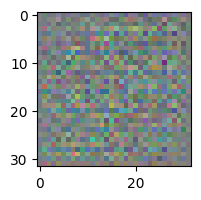

In [108]:
z = torch.randn(1, 512)
gen = Generator()
plt.figure(figsize=(2, 2))
plt.imshow(gen(z).view(3, 32, 32).permute(1,2,0).detach().numpy())
plt.show()

In [45]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = torch.nn.Sequential(
            torch.nn.Linear(3072, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024,512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 1),
            torch.nn.Sigmoid(),
        )

        
    def forward(self, x):
        """ Classifie un batch d'images en tant que vraie (1) ou fausse (0)
            Args:
                x (tensor torch, dim(batch_size x 3x32x32)) : batch de bruits initiaux
            Output:
                label (tensor torch, dim(batch_size)) : tensor de labels prédits des images (vraies ou fausses)
        """
        x_flat = x.view(-1, 3072)
        return self.model(x_flat)

In [122]:
disc = Discriminator()
test_disc = torch.stack((trainset[0][0],trainset[1][0],trainset[2][0]))
disc(test_disc).shape

torch.Size([3, 1])

In [19]:
class GAN(torch.nn.Module):
    def __init__(self, z_dim=512):
        super(GAN, self).__init__()
        
        self.z_dim = z_dim
        self.generator = Generator(z_dim)
        self.discriminator = Discriminator()
        
    
    def forward(self, z):
        """ Génère un batch d'images à partir d'un batch de bruits initiaux
            Args:
                z (tensor torch, dim(batch_size x z_dim)) : batch de bruits initiaux
            Output:
                x_prime (tensor torch, dim(batch_size x 3x32x32)) : batch d'images générées
        """
        return self.generator(z)
    
    
    def train_model(self, data, epoch, optim_g, optim_d):
        """ Entraîne le modèle, à partir d'un batch d'images d'entraînement pour le discriminateur
            Label = 1 pour les vraies données, 0 pour les données générées par le Generator
            Args:
                data (dataloader torch, dim(dataset_size x 3x32x32)) : jeu complet d'images initiales (en batchs)
                epoch : nombre d'itérations à réaliser sur le jeu d'entraînement complet
                optim_g : optimiseur pour le générateur
                optim_d : optimiseur pour le discriminateur
        """
        losses_true, losses_fake, losses_generator = [], [], []
        for e in tqdm(range(epoch)):
            train_loss_true, train_loss_fake, train_loss_g = 0, 0, 0
            for batch in data:
                # 1) Entraînement du discriminator : max log(D(x)) + log(1 - D(G(z)))
                #     Entraînement sur les vraies données (label=1)
                x = batch[0].to(torch.device("cuda"))
                batch_size = x.shape[0]
                optim_d.zero_grad()
                label_true = torch.full((batch_size, 1), 1, dtype=x.dtype, device=torch.device("cuda"))
                loss_true = binary_cross_entropy(self.discriminator(x), label_true)
                train_loss_true += loss_true.item()
                loss_true.backward()
                
                #     Entraînement sur les données générées par le générateur (label=0)
                z = torch.randn(batch_size, self.z_dim, device=torch.device("cuda"))
                x_prime = self.generator(z)
                label_fake = torch.full((batch_size, 1), 0, dtype=x.dtype, device=torch.device("cuda"))
                loss_fake = binary_cross_entropy(self.discriminator(x_prime.detach()), label_fake)
                train_loss_fake += loss_fake.item()
                loss_fake.backward()
                optim_d.step()
                
                # 2) Entraînement du generator : max log(D(G(z)))
                optim_g.zero_grad()
                # Les images bien générées sont celles classifiées en 1 par le discriminateur
                loss_generator = binary_cross_entropy(self.discriminator(x_prime), label_true)
                train_loss_g += loss_generator.item()
                loss_generator.backward()
                optim_g.step()
                
            print(f"{datetime.now().strftime('%H:%M:%S')} : Epoch {e} - Loss Discriminator {(train_loss_true + train_loss_fake)/len(data):.2f} - Loss Generator {train_loss_g/len(data):.2f}")
            losses_true.append(train_loss_true/len(data))
            losses_fake.append(train_loss_fake/len(data))
            losses_generator.append(train_loss_g/len(data))
        return losses_true, losses_fake, losses_generator

### 1 Epoch

In [153]:
gan = GAN().to(torch.device("cuda"))
optim_g = torch.optim.Adam(gan.generator.parameters())
optim_d = torch.optim.Adam(gan.discriminator.parameters())
losses_true, losses_fake, losses_generator = gan.train_model(data_train, 1, optim_g, optim_d)

  0%|          | 0/1 [00:00<?, ?it/s]

19:35:12 : Epoch 0 - Loss Discriminator 0.72 - Loss Generator 1.97


In [154]:
losses_true, losses_fake, losses_generator

([0.38634296943167235], [0.33431051764160546], [1.9688433579485614])

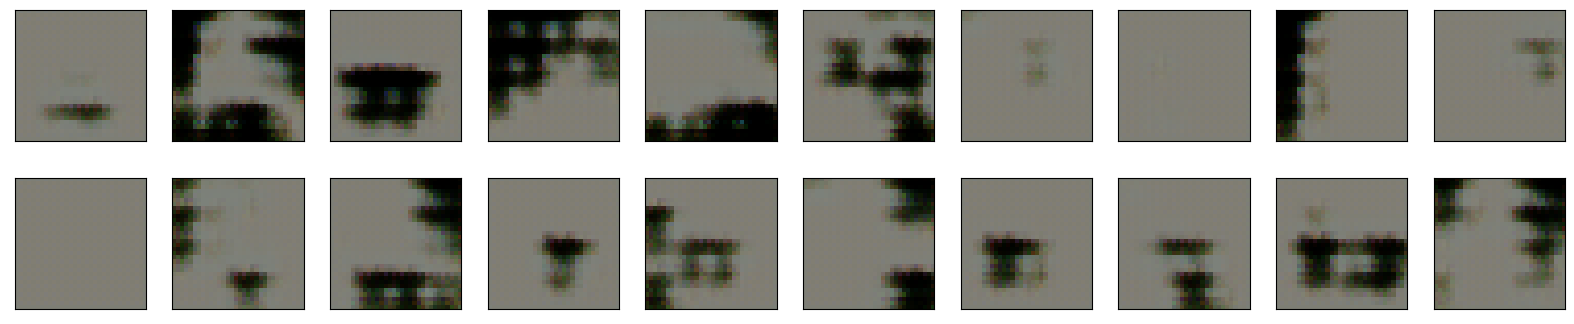

In [155]:
number = 10
plt.figure(figsize=(20, 4))
z = torch.randn(2*number, 512).to(torch.device("cuda"))
generated = gan(z)
for i in range(number):
    ax = plt.subplot(2, number, i + 1)
    plt.imshow(generated[i].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, number, i + 1 + number)
    plt.imshow(generated[i+number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### 10 Epoch

In [156]:
gan = GAN().to(torch.device("cuda"))
optim_g = torch.optim.Adam(gan.generator.parameters())
optim_d = torch.optim.Adam(gan.discriminator.parameters())
losses_true, losses_fake, losses_generator = gan.train_model(data_train, 10, optim_g, optim_d)

  0%|          | 0/10 [00:00<?, ?it/s]

19:35:26 : Epoch 0 - Loss Discriminator 0.70 - Loss Generator 2.11
19:35:41 : Epoch 1 - Loss Discriminator 0.72 - Loss Generator 1.83
19:35:54 : Epoch 2 - Loss Discriminator 0.86 - Loss Generator 1.48
19:36:08 : Epoch 3 - Loss Discriminator 0.92 - Loss Generator 1.37
19:36:22 : Epoch 4 - Loss Discriminator 1.03 - Loss Generator 1.23
19:36:35 : Epoch 5 - Loss Discriminator 1.09 - Loss Generator 1.23
19:36:49 : Epoch 6 - Loss Discriminator 1.21 - Loss Generator 1.01
19:37:03 : Epoch 7 - Loss Discriminator 1.26 - Loss Generator 1.02
19:37:16 : Epoch 8 - Loss Discriminator 1.24 - Loss Generator 1.00
19:37:30 : Epoch 9 - Loss Discriminator 1.28 - Loss Generator 0.93


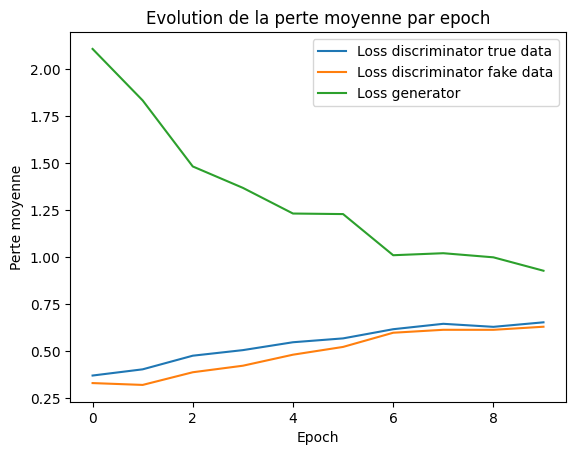

In [157]:
ab = np.arange(10)
plt.plot(ab, losses_true, label="Loss discriminator true data")
plt.plot(ab, losses_fake, label="Loss discriminator fake data")
plt.plot(ab, losses_generator, label="Loss generator")
plt.xlabel("Epoch")
plt.ylabel("Perte moyenne")
plt.title("Evolution de la perte moyenne par epoch")
plt.legend()
plt.show()

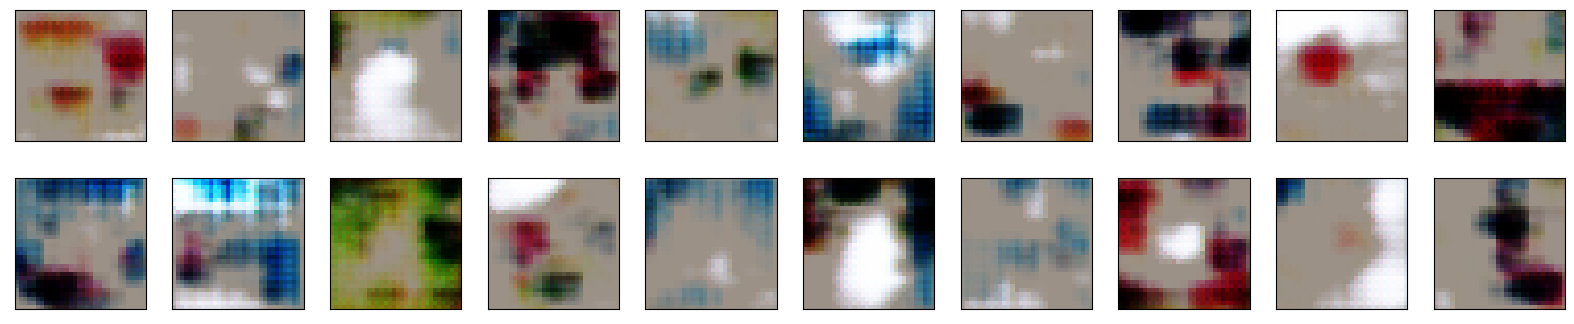

In [158]:
number = 10
plt.figure(figsize=(20, 4))
z = torch.randn(2*number, 512).to(torch.device("cuda"))
generated = gan(z)
for i in range(number):
    ax = plt.subplot(2, number, i + 1)
    plt.imshow(generated[i].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, number, i + 1 + number)
    plt.imshow(generated[i+number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### 100 Epoch

In [159]:
gan = GAN().to(torch.device("cuda"))
optim_g = torch.optim.Adam(gan.generator.parameters())
optim_d = torch.optim.Adam(gan.discriminator.parameters())
losses_true, losses_fake, losses_generator = gan.train_model(data_train, 100, optim_g, optim_d)

  0%|          | 0/100 [00:00<?, ?it/s]

19:37:44 : Epoch 0 - Loss Discriminator 0.73 - Loss Generator 2.01
19:37:58 : Epoch 1 - Loss Discriminator 0.65 - Loss Generator 1.96
19:38:12 : Epoch 2 - Loss Discriminator 0.82 - Loss Generator 1.58
19:38:25 : Epoch 3 - Loss Discriminator 0.90 - Loss Generator 1.43
19:38:39 : Epoch 4 - Loss Discriminator 0.96 - Loss Generator 1.32
19:38:53 : Epoch 5 - Loss Discriminator 1.02 - Loss Generator 1.20
19:39:06 : Epoch 6 - Loss Discriminator 1.11 - Loss Generator 1.06
19:39:21 : Epoch 7 - Loss Discriminator 1.11 - Loss Generator 1.12
19:39:35 : Epoch 8 - Loss Discriminator 1.19 - Loss Generator 0.93
19:39:49 : Epoch 9 - Loss Discriminator 1.16 - Loss Generator 1.03
19:40:02 : Epoch 10 - Loss Discriminator 1.22 - Loss Generator 0.89
19:40:16 : Epoch 11 - Loss Discriminator 1.19 - Loss Generator 1.20
19:40:30 : Epoch 12 - Loss Discriminator 1.16 - Loss Generator 1.16
19:40:43 : Epoch 13 - Loss Discriminator 1.14 - Loss Generator 1.00
19:40:57 : Epoch 14 - Loss Discriminator 1.15 - Loss Gener

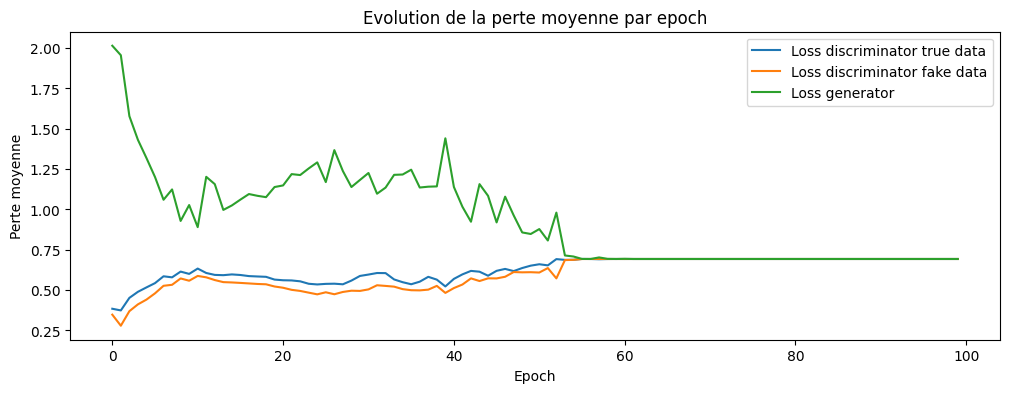

In [165]:
plt.figure(figsize=(12, 4))
ab = np.arange(100)
plt.plot(ab, losses_true, label="Loss discriminator true data")
plt.plot(ab, losses_fake, label="Loss discriminator fake data")
plt.plot(ab, losses_generator, label="Loss generator")
plt.xlabel("Epoch")
plt.ylabel("Perte moyenne")
plt.title("Evolution de la perte moyenne par epoch")
plt.legend()
plt.show()

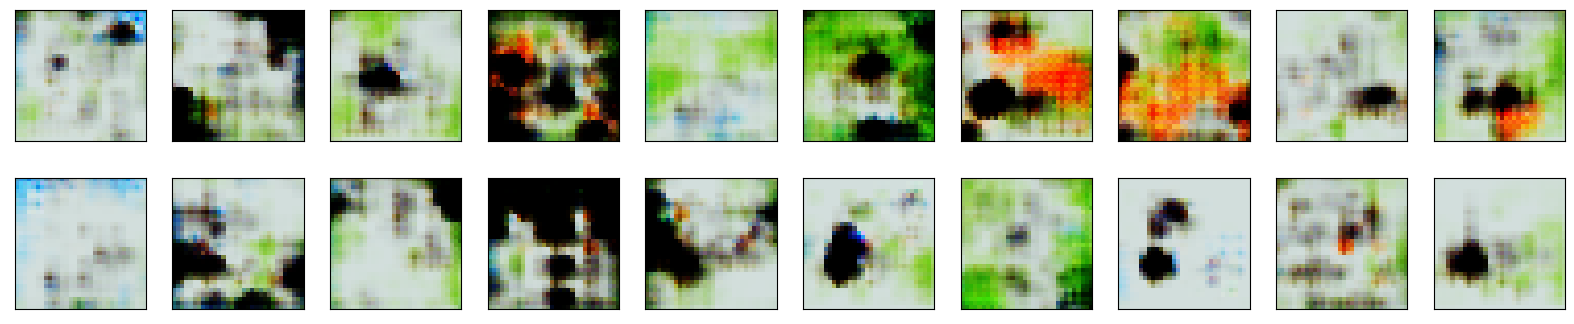

In [162]:
number = 10
plt.figure(figsize=(20, 4))
z = torch.randn(2*number, 512).to(torch.device("cuda"))
generated = gan(z)
for i in range(number):
    ax = plt.subplot(2, number, i + 1)
    plt.imshow(generated[i].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, number, i + 1 + number)
    plt.imshow(generated[i+number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Convergence obtenue ... mais discriminator "trop faible" : la loss du discriminator ne fait qu'augmenter (à part epoch 0 à 1), il n'arrive pas bien à discriminer les images vraies/fausses. Le generateur n'a donc pas besoin d'apprendre des images réalistes pour le tromper

## Test 2

In [18]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(3, 12, 4, stride=2, padding=1),           # [batch, 12, 16, 16]
            torch.nn.ReLU(),
            torch.nn.Conv2d(12, 24, 4, stride=2, padding=1),          # [batch, 24, 8, 8]
            torch.nn.BatchNorm2d(24),
            torch.nn.ReLU(),
            torch.nn.Conv2d(24, 48, 4, stride=2, padding=1),          # [batch, 48, 4, 4]
            torch.nn.BatchNorm2d(48),
            torch.nn.ReLU(),
            torch.nn.Conv2d(48, 1, 4, stride=1, padding=0),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        """ Classifie un batch d'images en tant que vraie (1) ou fausse (0)
            Args:
                x (tensor torch, dim(batch_size x 3x32x32)) : batch de bruits initiaux
            Output:
                label (tensor torch, dim(batch_size)) : tensor de labels prédits des images (vraies ou fausses)
        """
        return self.model(x).view(-1, 1)

### 1 Epoch

In [20]:
gan = GAN().to(torch.device("cuda"))
optim_g = torch.optim.Adam(gan.generator.parameters())
optim_d = torch.optim.Adam(gan.discriminator.parameters())
losses_true, losses_fake, losses_generator = gan.train_model(data_train, 1, optim_g, optim_d)

  0%|          | 0/1 [00:00<?, ?it/s]

11:12:31 : Epoch 0 - Loss Discriminator 0.14 - Loss Generator 5.49


In [21]:
losses_true, losses_fake, losses_generator

([0.07701630544861979], [0.06547626576648163], [5.491123859346943])

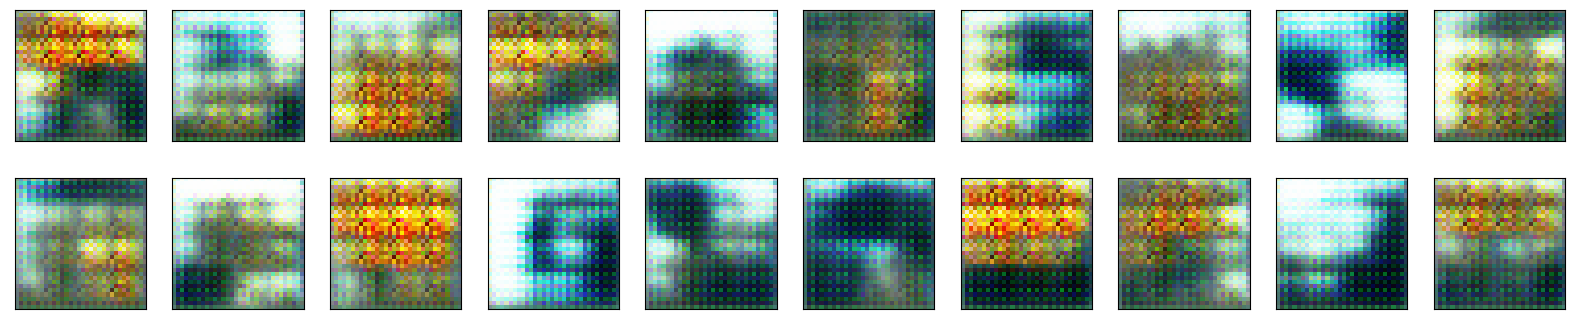

In [22]:
number = 10
plt.figure(figsize=(20, 4))
z = torch.randn(2*number, 512).to(torch.device("cuda"))
generated = gan(z)
for i in range(number):
    ax = plt.subplot(2, number, i + 1)
    plt.imshow(generated[i].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, number, i + 1 + number)
    plt.imshow(generated[i+number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### 10 Epoch

In [23]:
gan = GAN().to(torch.device("cuda"))
optim_g = torch.optim.Adam(gan.generator.parameters())
optim_d = torch.optim.Adam(gan.discriminator.parameters())
losses_true, losses_fake, losses_generator = gan.train_model(data_train, 10, optim_g, optim_d)

  0%|          | 0/10 [00:00<?, ?it/s]

11:13:23 : Epoch 0 - Loss Discriminator 0.19 - Loss Generator 4.94
11:13:42 : Epoch 1 - Loss Discriminator 0.26 - Loss Generator 4.53
11:14:02 : Epoch 2 - Loss Discriminator 0.38 - Loss Generator 3.87
11:14:20 : Epoch 3 - Loss Discriminator 0.44 - Loss Generator 3.55
11:14:36 : Epoch 4 - Loss Discriminator 0.42 - Loss Generator 3.92
11:14:53 : Epoch 5 - Loss Discriminator 0.44 - Loss Generator 3.67
11:15:09 : Epoch 6 - Loss Discriminator 0.48 - Loss Generator 3.60
11:15:25 : Epoch 7 - Loss Discriminator 0.60 - Loss Generator 3.08
11:15:42 : Epoch 8 - Loss Discriminator 0.55 - Loss Generator 3.12
11:15:58 : Epoch 9 - Loss Discriminator 0.63 - Loss Generator 3.11


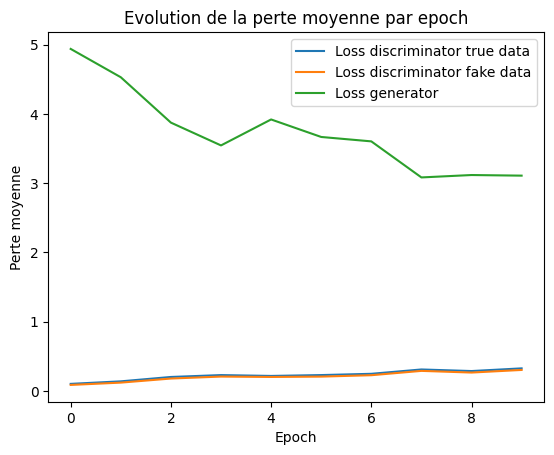

In [24]:
ab = np.arange(10)
plt.plot(ab, losses_true, label="Loss discriminator true data")
plt.plot(ab, losses_fake, label="Loss discriminator fake data")
plt.plot(ab, losses_generator, label="Loss generator")
plt.xlabel("Epoch")
plt.ylabel("Perte moyenne")
plt.title("Evolution de la perte moyenne par epoch")
plt.legend()
plt.show()

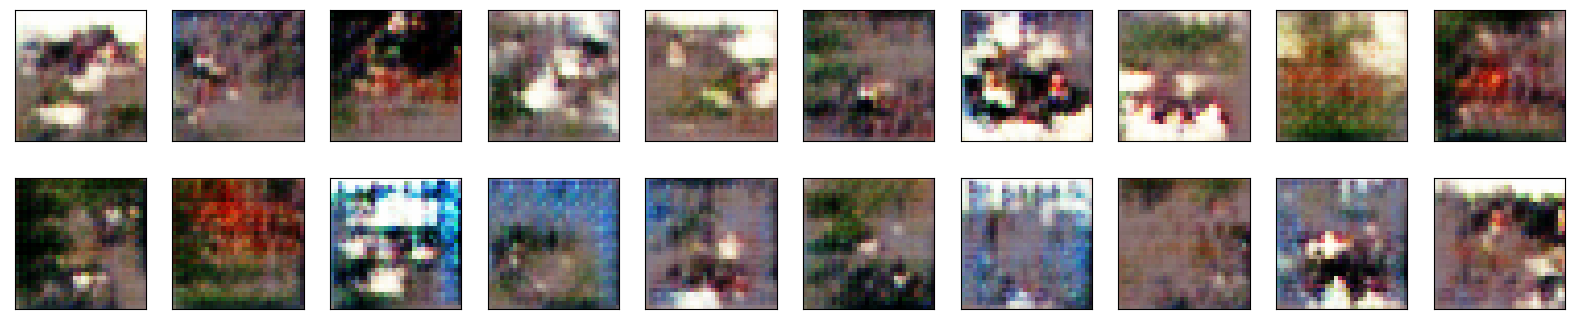

In [25]:
number = 10
plt.figure(figsize=(20, 4))
z = torch.randn(2*number, 512).to(torch.device("cuda"))
generated = gan(z)
for i in range(number):
    ax = plt.subplot(2, number, i + 1)
    plt.imshow(generated[i].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, number, i + 1 + number)
    plt.imshow(generated[i+number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### 100 Epoch

In [26]:
gan = GAN().to(torch.device("cuda"))
optim_g = torch.optim.Adam(gan.generator.parameters())
optim_d = torch.optim.Adam(gan.discriminator.parameters())
losses_true, losses_fake, losses_generator = gan.train_model(data_train, 100, optim_g, optim_d)

  0%|          | 0/100 [00:00<?, ?it/s]

11:16:16 : Epoch 0 - Loss Discriminator 0.16 - Loss Generator 5.41
11:16:32 : Epoch 1 - Loss Discriminator 0.26 - Loss Generator 4.33
11:16:49 : Epoch 2 - Loss Discriminator 0.36 - Loss Generator 4.20
11:17:05 : Epoch 3 - Loss Discriminator 0.35 - Loss Generator 3.95
11:17:22 : Epoch 4 - Loss Discriminator 0.40 - Loss Generator 3.94
11:17:38 : Epoch 5 - Loss Discriminator 0.46 - Loss Generator 3.86
11:17:55 : Epoch 6 - Loss Discriminator 0.46 - Loss Generator 3.60
11:18:11 : Epoch 7 - Loss Discriminator 0.41 - Loss Generator 3.82
11:18:28 : Epoch 8 - Loss Discriminator 0.43 - Loss Generator 4.01
11:18:45 : Epoch 9 - Loss Discriminator 0.50 - Loss Generator 3.41
11:19:01 : Epoch 10 - Loss Discriminator 0.55 - Loss Generator 3.27
11:19:19 : Epoch 11 - Loss Discriminator 0.57 - Loss Generator 3.06
11:19:36 : Epoch 12 - Loss Discriminator 0.68 - Loss Generator 2.87
11:19:53 : Epoch 13 - Loss Discriminator 0.72 - Loss Generator 2.62
11:20:09 : Epoch 14 - Loss Discriminator 0.66 - Loss Gener

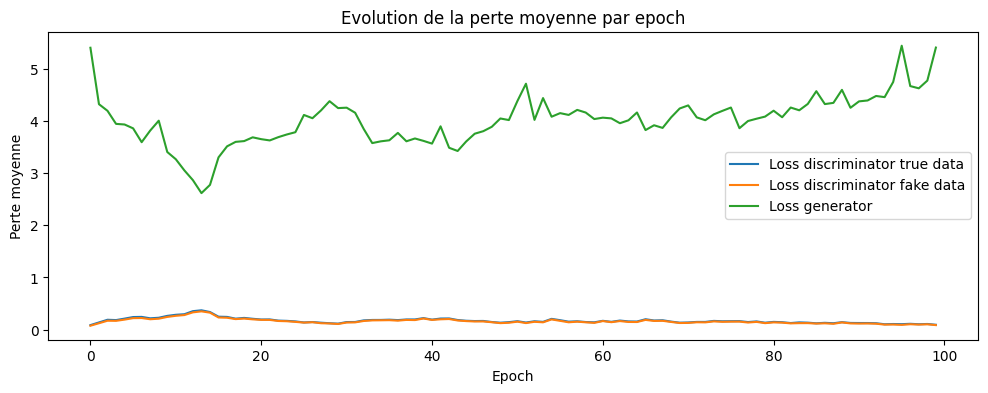

In [27]:
plt.figure(figsize=(12, 4))
ab = np.arange(100)
plt.plot(ab, losses_true, label="Loss discriminator true data")
plt.plot(ab, losses_fake, label="Loss discriminator fake data")
plt.plot(ab, losses_generator, label="Loss generator")
plt.xlabel("Epoch")
plt.ylabel("Perte moyenne")
plt.title("Evolution de la perte moyenne par epoch")
plt.legend()
plt.show()

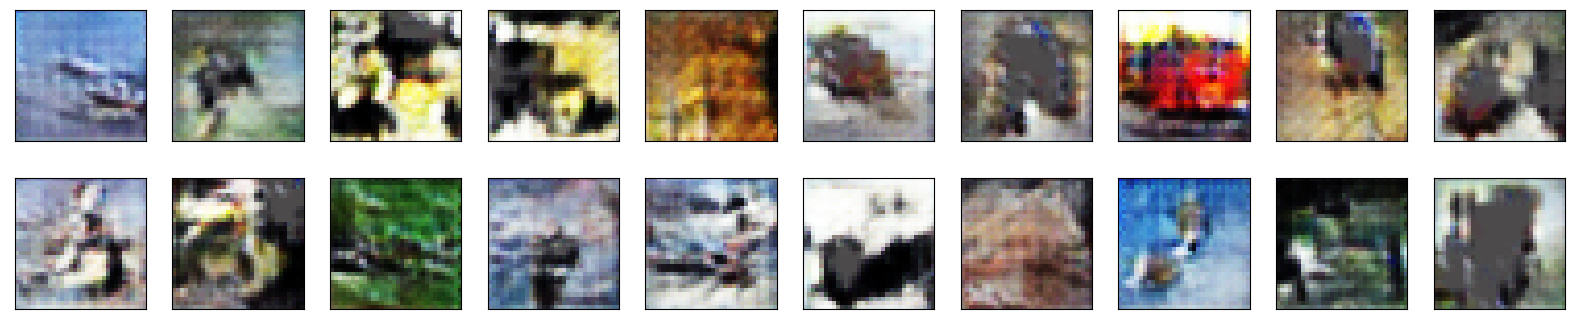

In [28]:
number = 10
plt.figure(figsize=(20, 4))
z = torch.randn(2*number, 512).to(torch.device("cuda"))
generated = gan(z)
for i in range(number):
    ax = plt.subplot(2, number, i + 1)
    plt.imshow(generated[i].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, number, i + 1 + number)
    plt.imshow(generated[i+number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Les images sont plus réalistes, mais ne ressemblent à rien. Il n'y a pas convergence, la loss du générateur ne baisse pas assez pour avoir des images réalistes

## Test 3

In [16]:
class Generator(torch.nn.Module):
    def __init__(self, z_dim=256):
        super(Generator, self).__init__()
        
        self.model = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(z_dim, 256, 4, stride=1, padding=0), # [batch, 256, 4, 4]
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), # [batch, 128, 8, 8]
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), # [batch, 64, 16, 16]
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),  # [batch, 3, 32, 32]
            torch.nn.Sigmoid()            
        )

        
    def forward(self, z):
        """ Génère un batch d'images à partir d'un batch de bruits initiaux
            Args:
                z (tensor torch, dim(batch_size x z_dim)) : batch de bruits initiaux
            Output:
                x_prime (tensor torch, dim(batch_size x 3x32x32)) : batch d'images générées
        """
        return self.model(z)

In [17]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(3, 64, 4, stride=2, padding=1),           # [batch, 64, 4, 4]
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 128, 4, stride=2, padding=1),          # [batch, 128, 2, 2]
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 256, 4, stride=2, padding=1),          # [batch, 256, 1, 1]
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256, 1, 4, stride=1, padding=0),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        """ Classifie un batch d'images en tant que vraie (1) ou fausse (0)
            Args:
                x (tensor torch, dim(batch_size x 3x32x32)) : batch de bruits initiaux
            Output:
                label (tensor torch, dim(batch_size)) : tensor de labels prédits des images (vraies ou fausses)
        """
        return self.model(x).view(-1, 1)

In [18]:
class GAN(torch.nn.Module):
    def __init__(self, z_dim=256):
        super(GAN, self).__init__()
        
        self.z_dim = z_dim
        self.generator = Generator(z_dim)
        self.discriminator = Discriminator()
        
    
    def forward(self, z):
        """ Génère un batch d'images à partir d'un batch de bruits initiaux
            Args:
                z (tensor torch, dim(batch_size x z_dim)) : batch de bruits initiaux
            Output:
                x_prime (tensor torch, dim(batch_size x 3x32x32)) : batch d'images générées
        """
        return self.generator(z)
    
    
    def train_model(self, data, epoch, optim_g, optim_d):
        """ Entraîne le modèle, à partir d'un batch d'images d'entraînement pour le discriminateur
            Label = 1 pour les vraies données, 0 pour les données générées par le Generator
            Args:
                data (dataloader torch, dim(dataset_size x 3x32x32)) : jeu complet d'images initiales (en batchs)
                epoch : nombre d'itérations à réaliser sur le jeu d'entraînement complet
                optim_g : optimiseur pour le générateur
                optim_d : optimiseur pour le discriminateur
        """
        losses_true, losses_fake, losses_generator = [], [], []
        for e in tqdm(range(epoch)):
            train_loss_true, train_loss_fake, train_loss_g = 0, 0, 0
            for batch in data:
                # 1) Entraînement du discriminator : max log(D(x)) + log(1 - D(G(z)))
                #     Entraînement sur les vraies données (label=1)
                x = batch[0].to(torch.device("cuda"))
                batch_size = x.shape[0]
                optim_d.zero_grad()
                label_true = torch.full((batch_size, 1), 1, dtype=x.dtype, device=torch.device("cuda"))
                loss_true = binary_cross_entropy(self.discriminator(x), label_true)
                train_loss_true += loss_true.item()
                loss_true.backward()
                
                #     Entraînement sur les données générées par le générateur (label=0)
                z = torch.randn(batch_size, self.z_dim, 1, 1, device=torch.device("cuda"))
                x_prime = self.generator(z)
                label_fake = torch.full((batch_size, 1), 0, dtype=x.dtype, device=torch.device("cuda"))
                loss_fake = binary_cross_entropy(self.discriminator(x_prime.detach()), label_fake)
                train_loss_fake += loss_fake.item()
                loss_fake.backward()
                optim_d.step()
                
                # 2) Entraînement du generator : max log(D(G(z)))
                optim_g.zero_grad()
                # Les images bien générées sont celles classifiées en 1 par le discriminateur
                loss_generator = binary_cross_entropy(self.discriminator(x_prime), label_true)
                train_loss_g += loss_generator.item()
                loss_generator.backward()
                optim_g.step()
                
            print(f"{datetime.now().strftime('%H:%M:%S')} : Epoch {e} - Loss Discriminator {(train_loss_true + train_loss_fake)/len(data):.2f} - Loss Generator {train_loss_g/len(data):.2f}")
            losses_true.append(train_loss_true/len(data))
            losses_fake.append(train_loss_fake/len(data))
            losses_generator.append(train_loss_g/len(data))
        return losses_true, losses_fake, losses_generator

### 1 epoch

In [73]:
gan = GAN().to(torch.device("cuda"))
optim_g = torch.optim.Adam(gan.generator.parameters())
optim_d = torch.optim.Adam(gan.discriminator.parameters())
losses_true, losses_fake, losses_generator = gan.train_model(data_train, 1, optim_g, optim_d)

  0%|          | 0/1 [00:00<?, ?it/s]

13:36:36 : Epoch 0 - Loss Discriminator 0.11 - Loss Generator 8.07


In [74]:
losses_true, losses_fake, losses_generator

([0.0594280389377469], [0.05329716491545696], [8.072477373627615])

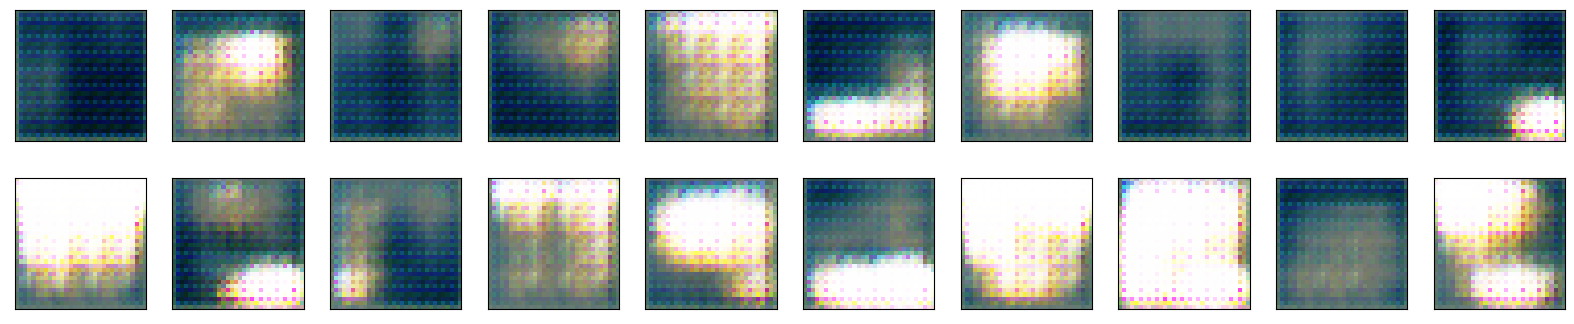

In [75]:
number = 10
plt.figure(figsize=(20, 4))
z = torch.randn(2*number, 256, 1, 1).to(torch.device("cuda"))
generated = gan(z)
for i in range(number):
    ax = plt.subplot(2, number, i + 1)
    plt.imshow(generated[i].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, number, i + 1 + number)
    plt.imshow(generated[i+number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### 10 epoch

In [76]:
gan = GAN().to(torch.device("cuda"))
optim_g = torch.optim.Adam(gan.generator.parameters())
optim_d = torch.optim.Adam(gan.discriminator.parameters())
losses_true, losses_fake, losses_generator = gan.train_model(data_train, 10, optim_g, optim_d)

  0%|          | 0/10 [00:00<?, ?it/s]

13:37:07 : Epoch 0 - Loss Discriminator 0.12 - Loss Generator 7.74
13:37:24 : Epoch 1 - Loss Discriminator 0.17 - Loss Generator 8.02
13:37:41 : Epoch 2 - Loss Discriminator 0.17 - Loss Generator 7.29
13:37:58 : Epoch 3 - Loss Discriminator 0.17 - Loss Generator 7.39
13:38:15 : Epoch 4 - Loss Discriminator 0.17 - Loss Generator 7.03
13:38:32 : Epoch 5 - Loss Discriminator 0.19 - Loss Generator 6.36
13:38:49 : Epoch 6 - Loss Discriminator 0.20 - Loss Generator 6.24
13:39:06 : Epoch 7 - Loss Discriminator 0.23 - Loss Generator 6.13
13:39:23 : Epoch 8 - Loss Discriminator 0.23 - Loss Generator 5.72
13:39:40 : Epoch 9 - Loss Discriminator 0.29 - Loss Generator 5.42


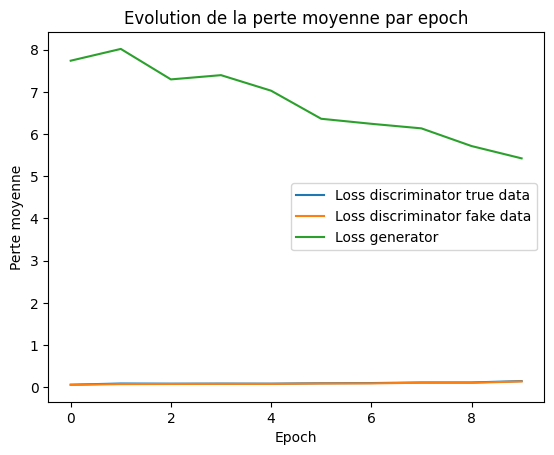

In [77]:
ab = np.arange(10)
plt.plot(ab, losses_true, label="Loss discriminator true data")
plt.plot(ab, losses_fake, label="Loss discriminator fake data")
plt.plot(ab, losses_generator, label="Loss generator")
plt.xlabel("Epoch")
plt.ylabel("Perte moyenne")
plt.title("Evolution de la perte moyenne par epoch")
plt.legend()
plt.show()

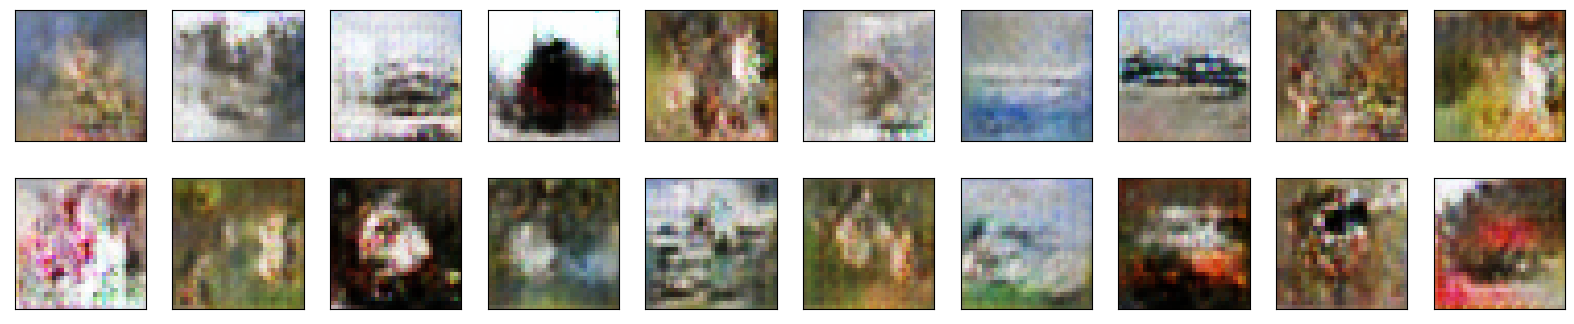

In [78]:
number = 10
plt.figure(figsize=(20, 4))
z = torch.randn(2*number, 256, 1, 1).to(torch.device("cuda"))
generated = gan(z)
for i in range(number):
    ax = plt.subplot(2, number, i + 1)
    plt.imshow(generated[i].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, number, i + 1 + number)
    plt.imshow(generated[i+number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### 100 epoch

In [79]:
gan = GAN().to(torch.device("cuda"))
optim_g = torch.optim.Adam(gan.generator.parameters())
optim_d = torch.optim.Adam(gan.discriminator.parameters())
losses_true, losses_fake, losses_generator = gan.train_model(data_train, 100, optim_g, optim_d)

  0%|          | 0/100 [00:00<?, ?it/s]

13:39:59 : Epoch 0 - Loss Discriminator 0.15 - Loss Generator 7.13
13:40:16 : Epoch 1 - Loss Discriminator 0.15 - Loss Generator 7.00
13:40:33 : Epoch 2 - Loss Discriminator 0.15 - Loss Generator 7.41
13:40:50 : Epoch 3 - Loss Discriminator 0.15 - Loss Generator 7.90
13:41:07 : Epoch 4 - Loss Discriminator 0.15 - Loss Generator 7.56
13:41:24 : Epoch 5 - Loss Discriminator 0.19 - Loss Generator 6.88
13:41:41 : Epoch 6 - Loss Discriminator 0.22 - Loss Generator 6.52
13:41:58 : Epoch 7 - Loss Discriminator 0.19 - Loss Generator 6.21
13:42:15 : Epoch 8 - Loss Discriminator 0.19 - Loss Generator 6.29
13:42:32 : Epoch 9 - Loss Discriminator 0.26 - Loss Generator 6.06
13:42:49 : Epoch 10 - Loss Discriminator 0.22 - Loss Generator 5.57
13:43:06 : Epoch 11 - Loss Discriminator 0.21 - Loss Generator 5.46
13:43:23 : Epoch 12 - Loss Discriminator 0.19 - Loss Generator 5.69
13:43:39 : Epoch 13 - Loss Discriminator 0.20 - Loss Generator 5.81
13:43:56 : Epoch 14 - Loss Discriminator 0.19 - Loss Gener

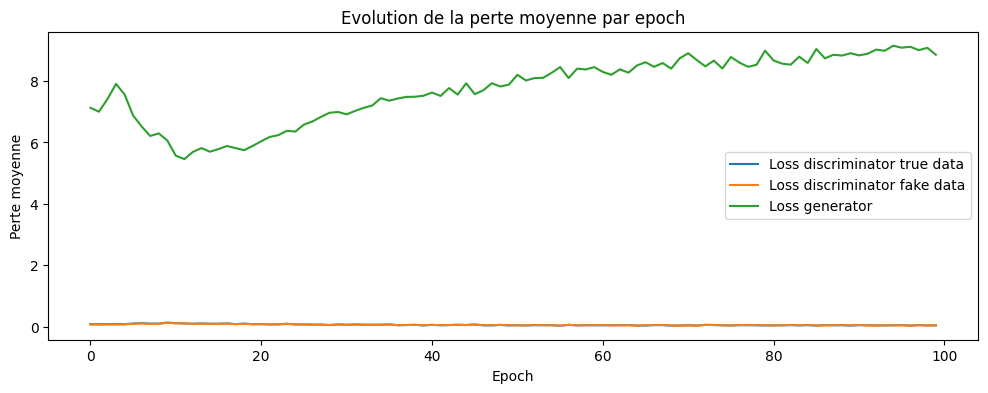

In [80]:
plt.figure(figsize=(12, 4))
ab = np.arange(100)
plt.plot(ab, losses_true, label="Loss discriminator true data")
plt.plot(ab, losses_fake, label="Loss discriminator fake data")
plt.plot(ab, losses_generator, label="Loss generator")
plt.xlabel("Epoch")
plt.ylabel("Perte moyenne")
plt.title("Evolution de la perte moyenne par epoch")
plt.legend()
plt.show()

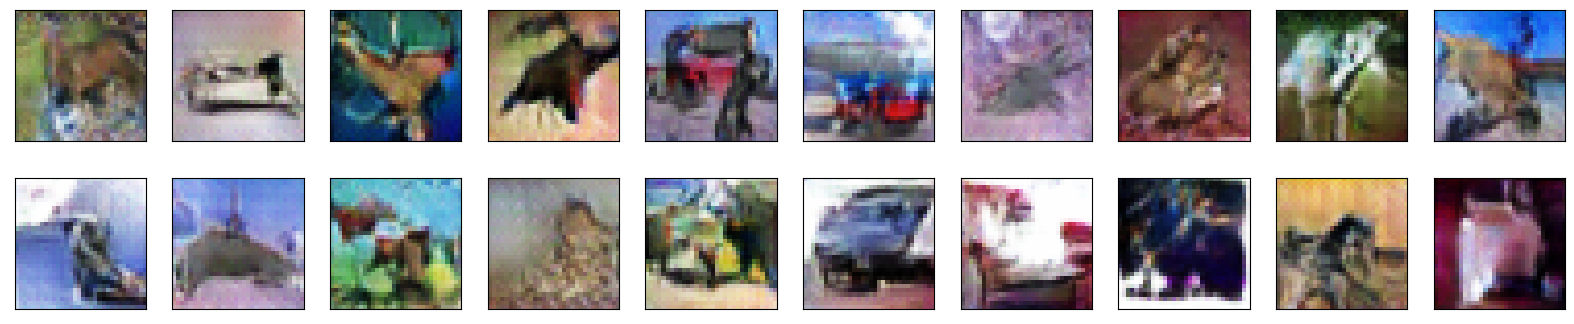

In [81]:
number = 10
plt.figure(figsize=(20, 4))
z = torch.randn(2*number, 256, 1, 1).to(torch.device("cuda"))
generated = gan(z)
for i in range(number):
    ax = plt.subplot(2, number, i + 1)
    plt.imshow(generated[i].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, number, i + 1 + number)
    plt.imshow(generated[i+number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

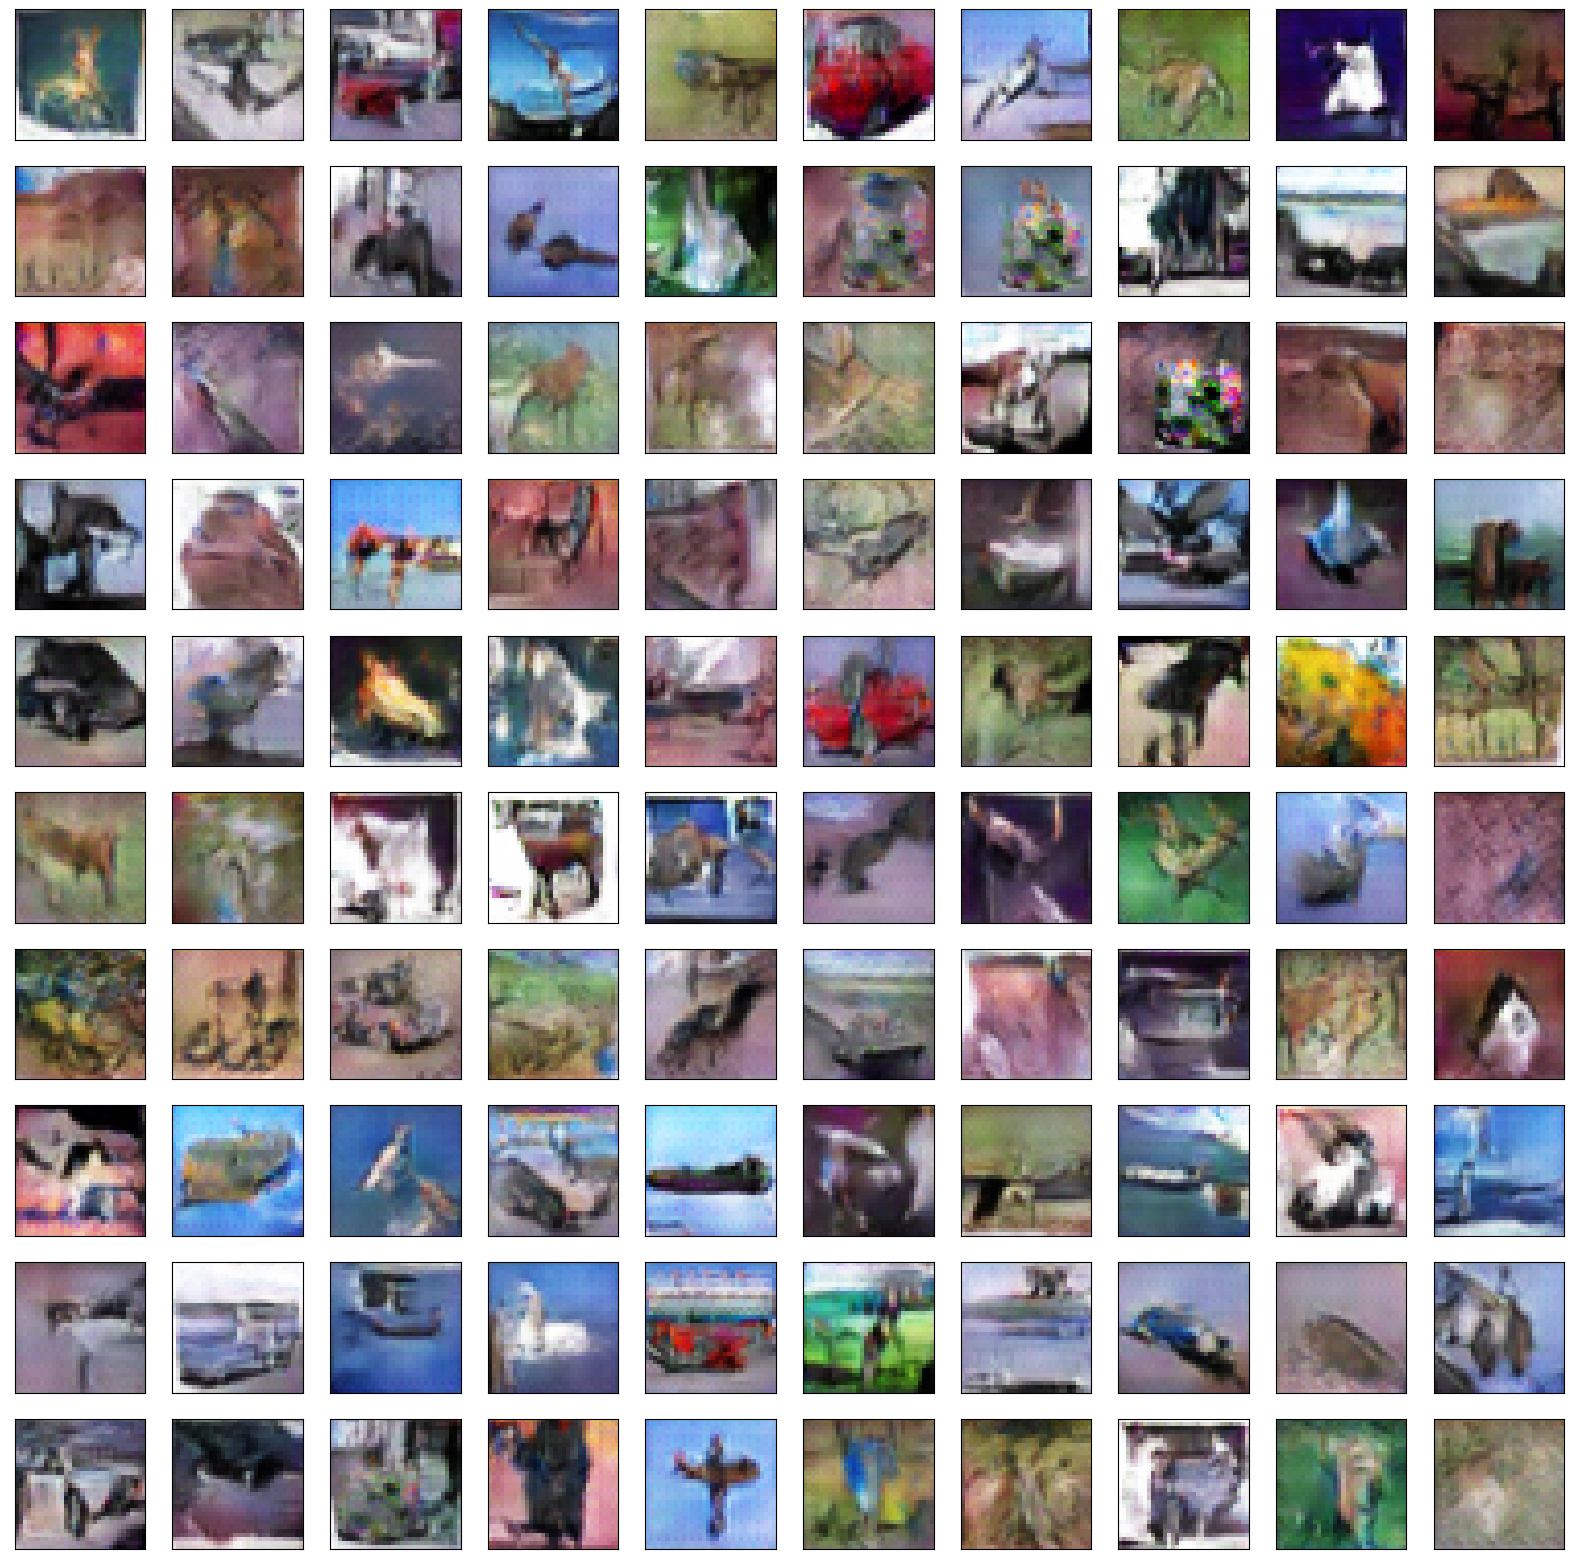

In [84]:
number = 10
plt.figure(figsize=(20, 20))
z = torch.randn(10*number, 256, 1, 1).to(torch.device("cuda"))
generated = gan(z)
for i in range(number):
    ax = plt.subplot(10, number, i + 1)
    plt.imshow(generated[i].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + number)
    plt.imshow(generated[i+number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 2*number)
    plt.imshow(generated[i+2*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 3*number)
    plt.imshow(generated[i+3*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 4*number)
    plt.imshow(generated[i+4*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 5*number)
    plt.imshow(generated[i+5*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 6*number)
    plt.imshow(generated[i+6*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 7*number)
    plt.imshow(generated[i+7*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 8*number)
    plt.imshow(generated[i+8*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 9*number)
    plt.imshow(generated[i+9*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### 150 epochs

In [22]:
gan = GAN().to(torch.device("cuda"))
optim_g = torch.optim.Adam(gan.generator.parameters())
optim_d = torch.optim.Adam(gan.discriminator.parameters())
losses_true, losses_fake, losses_generator = gan.train_model(data_train, 150, optim_g, optim_d)

  0%|          | 0/150 [00:00<?, ?it/s]

17:49:16 : Epoch 0 - Loss Discriminator 0.09 - Loss Generator 7.92
17:49:35 : Epoch 1 - Loss Discriminator 0.14 - Loss Generator 8.06
17:49:52 : Epoch 2 - Loss Discriminator 0.19 - Loss Generator 6.97
17:50:10 : Epoch 3 - Loss Discriminator 0.18 - Loss Generator 6.88
17:50:28 : Epoch 4 - Loss Discriminator 0.20 - Loss Generator 6.49
17:50:46 : Epoch 5 - Loss Discriminator 0.25 - Loss Generator 5.79
17:51:04 : Epoch 6 - Loss Discriminator 0.23 - Loss Generator 5.72
17:51:23 : Epoch 7 - Loss Discriminator 0.26 - Loss Generator 5.63
17:51:41 : Epoch 8 - Loss Discriminator 0.32 - Loss Generator 5.09
17:51:58 : Epoch 9 - Loss Discriminator 0.28 - Loss Generator 4.90
17:52:17 : Epoch 10 - Loss Discriminator 0.25 - Loss Generator 5.04
17:52:35 : Epoch 11 - Loss Discriminator 0.21 - Loss Generator 5.40
17:52:54 : Epoch 12 - Loss Discriminator 0.18 - Loss Generator 5.52
17:53:12 : Epoch 13 - Loss Discriminator 0.23 - Loss Generator 5.56
17:53:29 : Epoch 14 - Loss Discriminator 0.21 - Loss Gener

18:25:47 : Epoch 121 - Loss Discriminator 0.08 - Loss Generator 9.23
18:26:05 : Epoch 122 - Loss Discriminator 0.07 - Loss Generator 9.39
18:26:24 : Epoch 123 - Loss Discriminator 0.07 - Loss Generator 9.55
18:26:43 : Epoch 124 - Loss Discriminator 0.08 - Loss Generator 9.31
18:27:01 : Epoch 125 - Loss Discriminator 0.07 - Loss Generator 9.46
18:27:18 : Epoch 126 - Loss Discriminator 0.08 - Loss Generator 9.37
18:27:36 : Epoch 127 - Loss Discriminator 0.09 - Loss Generator 9.51
18:27:57 : Epoch 128 - Loss Discriminator 0.13 - Loss Generator 9.16
18:28:15 : Epoch 129 - Loss Discriminator 0.07 - Loss Generator 9.25
18:28:34 : Epoch 130 - Loss Discriminator 0.07 - Loss Generator 9.36
18:28:53 : Epoch 131 - Loss Discriminator 0.08 - Loss Generator 9.45
18:29:10 : Epoch 132 - Loss Discriminator 0.08 - Loss Generator 9.63
18:29:30 : Epoch 133 - Loss Discriminator 0.08 - Loss Generator 9.62
18:29:50 : Epoch 134 - Loss Discriminator 0.07 - Loss Generator 9.73
18:30:07 : Epoch 135 - Loss Discri

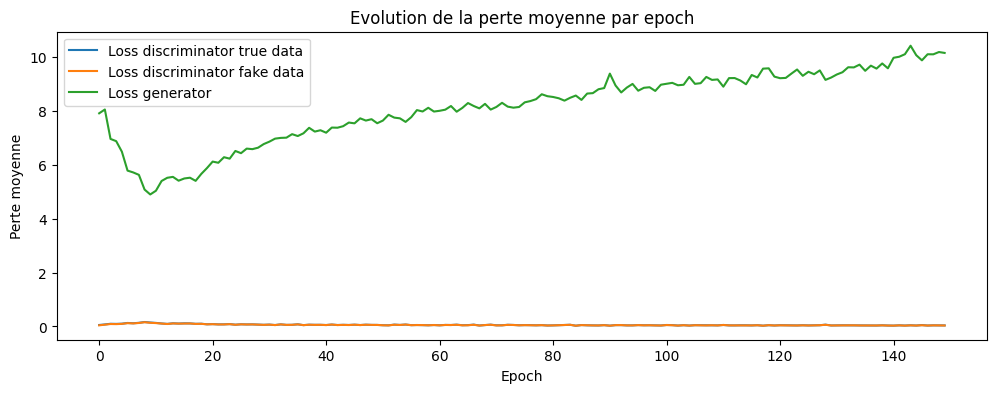

In [23]:
plt.figure(figsize=(12, 4))
ab = np.arange(150)
plt.plot(ab, losses_true, label="Loss discriminator true data")
plt.plot(ab, losses_fake, label="Loss discriminator fake data")
plt.plot(ab, losses_generator, label="Loss generator")
plt.xlabel("Epoch")
plt.ylabel("Perte moyenne")
plt.title("Evolution de la perte moyenne par epoch")
plt.legend()
plt.show()

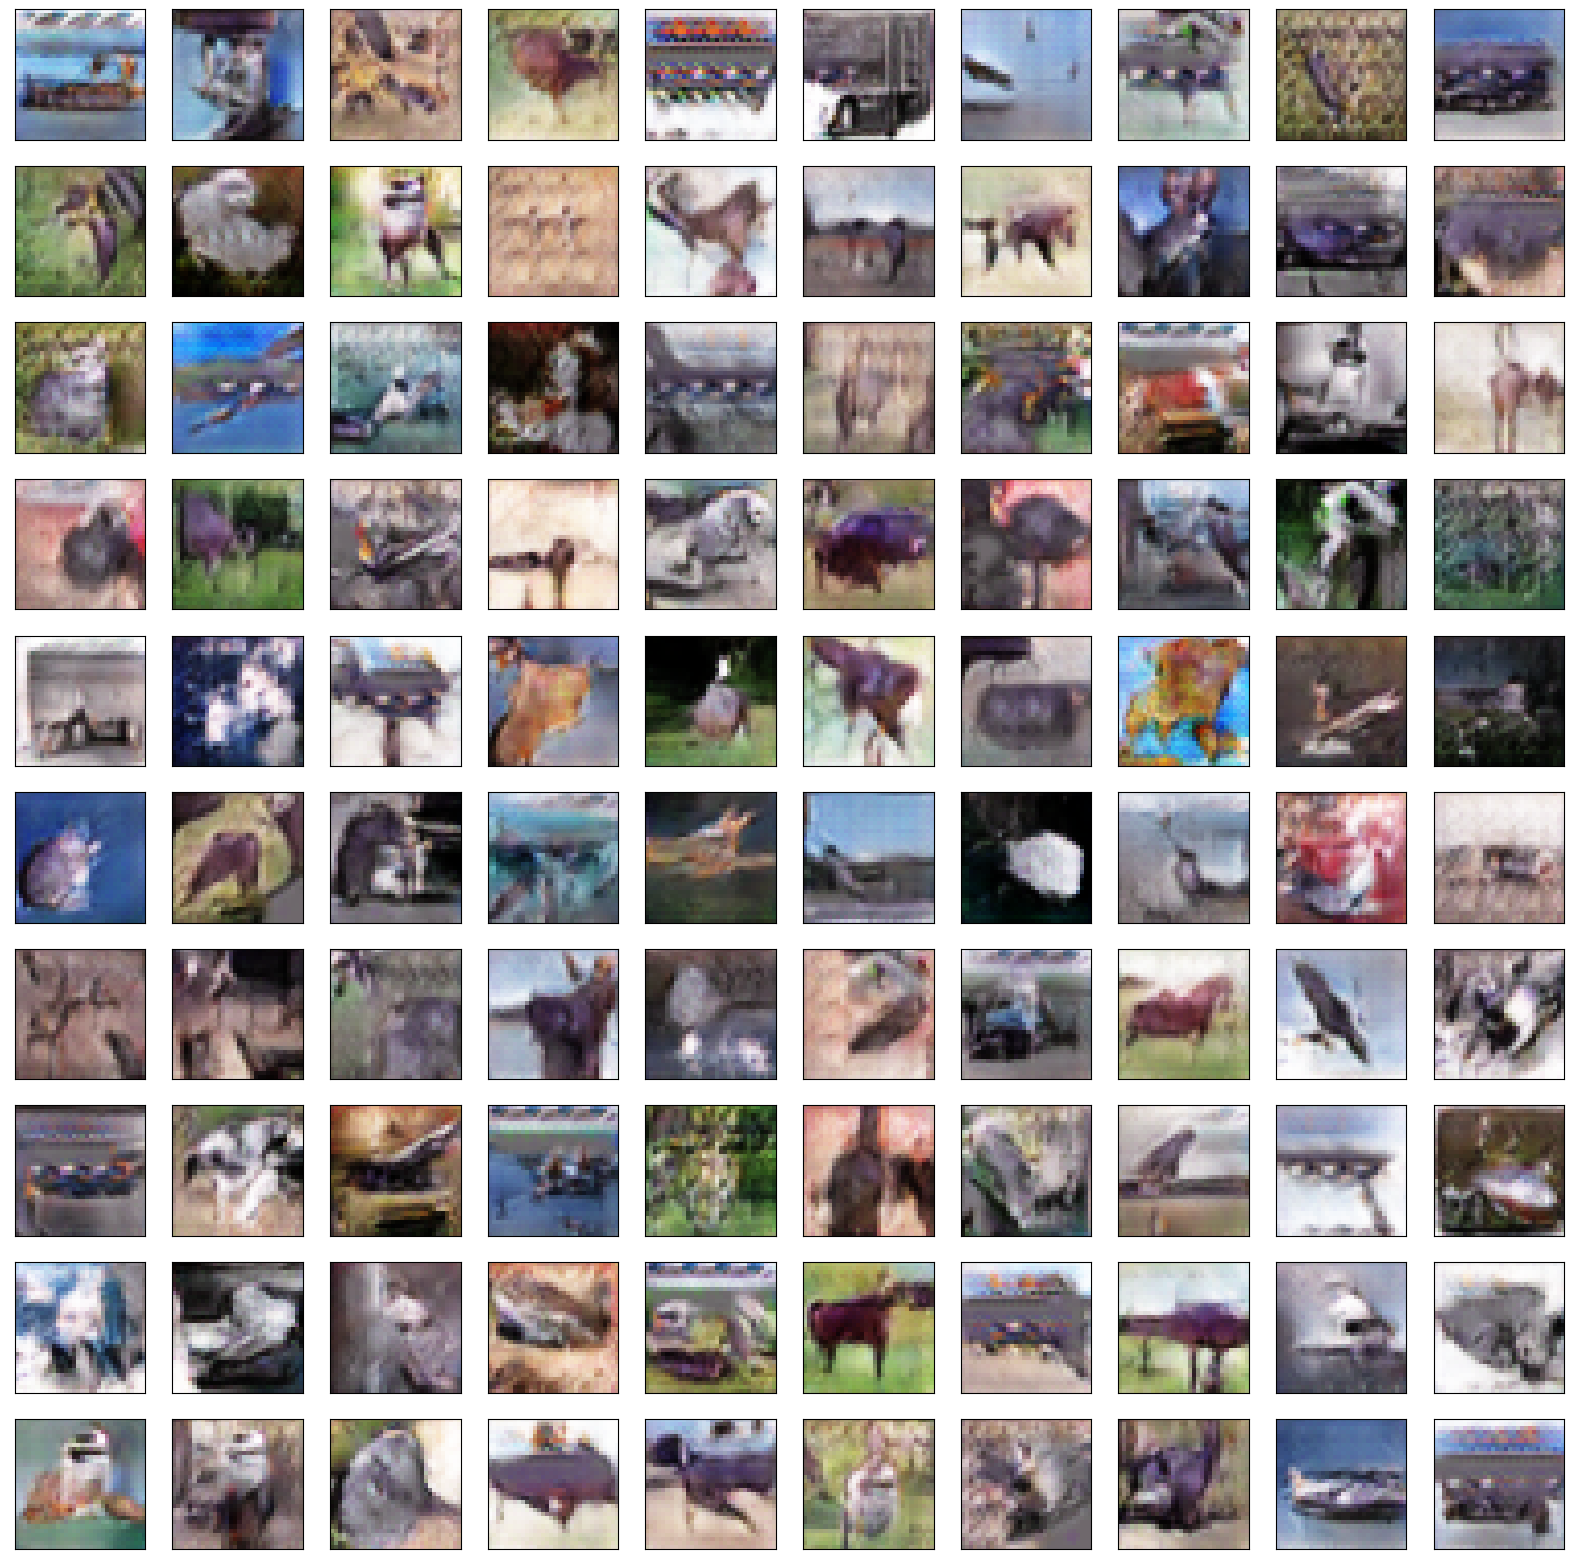

In [24]:
number = 10
plt.figure(figsize=(20, 20))
z = torch.randn(10*number, 256, 1, 1).to(torch.device("cuda"))
generated = gan(z)
for i in range(number):
    ax = plt.subplot(10, number, i + 1)
    plt.imshow(generated[i].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + number)
    plt.imshow(generated[i+number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 2*number)
    plt.imshow(generated[i+2*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 3*number)
    plt.imshow(generated[i+3*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 4*number)
    plt.imshow(generated[i+4*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 5*number)
    plt.imshow(generated[i+5*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 6*number)
    plt.imshow(generated[i+6*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 7*number)
    plt.imshow(generated[i+7*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 8*number)
    plt.imshow(generated[i+8*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 9*number)
    plt.imshow(generated[i+9*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### 1000 epochs

In [85]:
gan = GAN().to(torch.device("cuda"))
optim_g = torch.optim.Adam(gan.generator.parameters())
optim_d = torch.optim.Adam(gan.discriminator.parameters())
losses_true, losses_fake, losses_generator = gan.train_model(data_train, 1000, optim_g, optim_d)

  0%|          | 0/1000 [00:00<?, ?it/s]

20:39:18 : Epoch 0 - Loss Discriminator 0.14 - Loss Generator 7.17
20:39:38 : Epoch 1 - Loss Discriminator 0.17 - Loss Generator 7.21
20:39:57 : Epoch 2 - Loss Discriminator 0.18 - Loss Generator 7.37
20:40:14 : Epoch 3 - Loss Discriminator 0.14 - Loss Generator 7.83
20:40:31 : Epoch 4 - Loss Discriminator 0.17 - Loss Generator 7.38
20:40:51 : Epoch 5 - Loss Discriminator 0.22 - Loss Generator 6.61
20:41:10 : Epoch 6 - Loss Discriminator 0.24 - Loss Generator 6.12
20:41:30 : Epoch 7 - Loss Discriminator 0.19 - Loss Generator 6.13
20:41:49 : Epoch 8 - Loss Discriminator 0.24 - Loss Generator 6.15
20:42:06 : Epoch 9 - Loss Discriminator 0.27 - Loss Generator 5.57
20:42:23 : Epoch 10 - Loss Discriminator 0.31 - Loss Generator 5.12
20:42:39 : Epoch 11 - Loss Discriminator 0.27 - Loss Generator 5.03
20:42:56 : Epoch 12 - Loss Discriminator 0.24 - Loss Generator 4.97
20:43:13 : Epoch 13 - Loss Discriminator 0.20 - Loss Generator 5.39
20:43:30 : Epoch 14 - Loss Discriminator 0.19 - Loss Gener

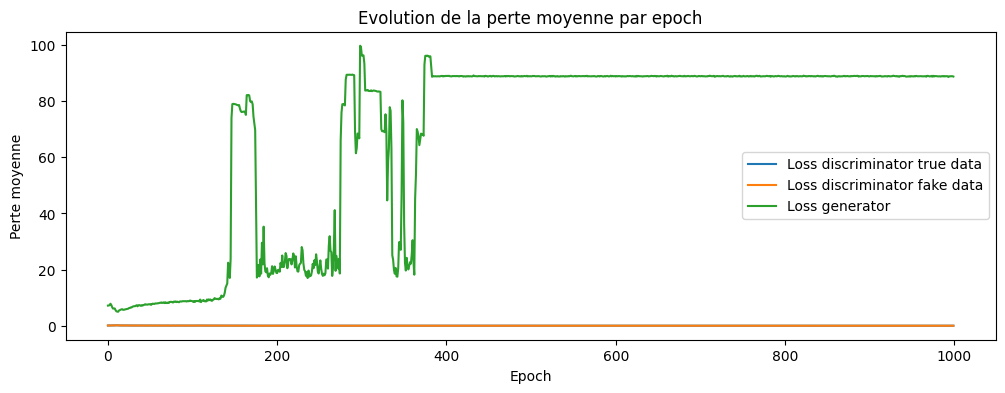

In [86]:
plt.figure(figsize=(12, 4))
ab = np.arange(1000)
plt.plot(ab, losses_true, label="Loss discriminator true data")
plt.plot(ab, losses_fake, label="Loss discriminator fake data")
plt.plot(ab, losses_generator, label="Loss generator")
plt.xlabel("Epoch")
plt.ylabel("Perte moyenne")
plt.title("Evolution de la perte moyenne par epoch")
plt.legend()
plt.show()

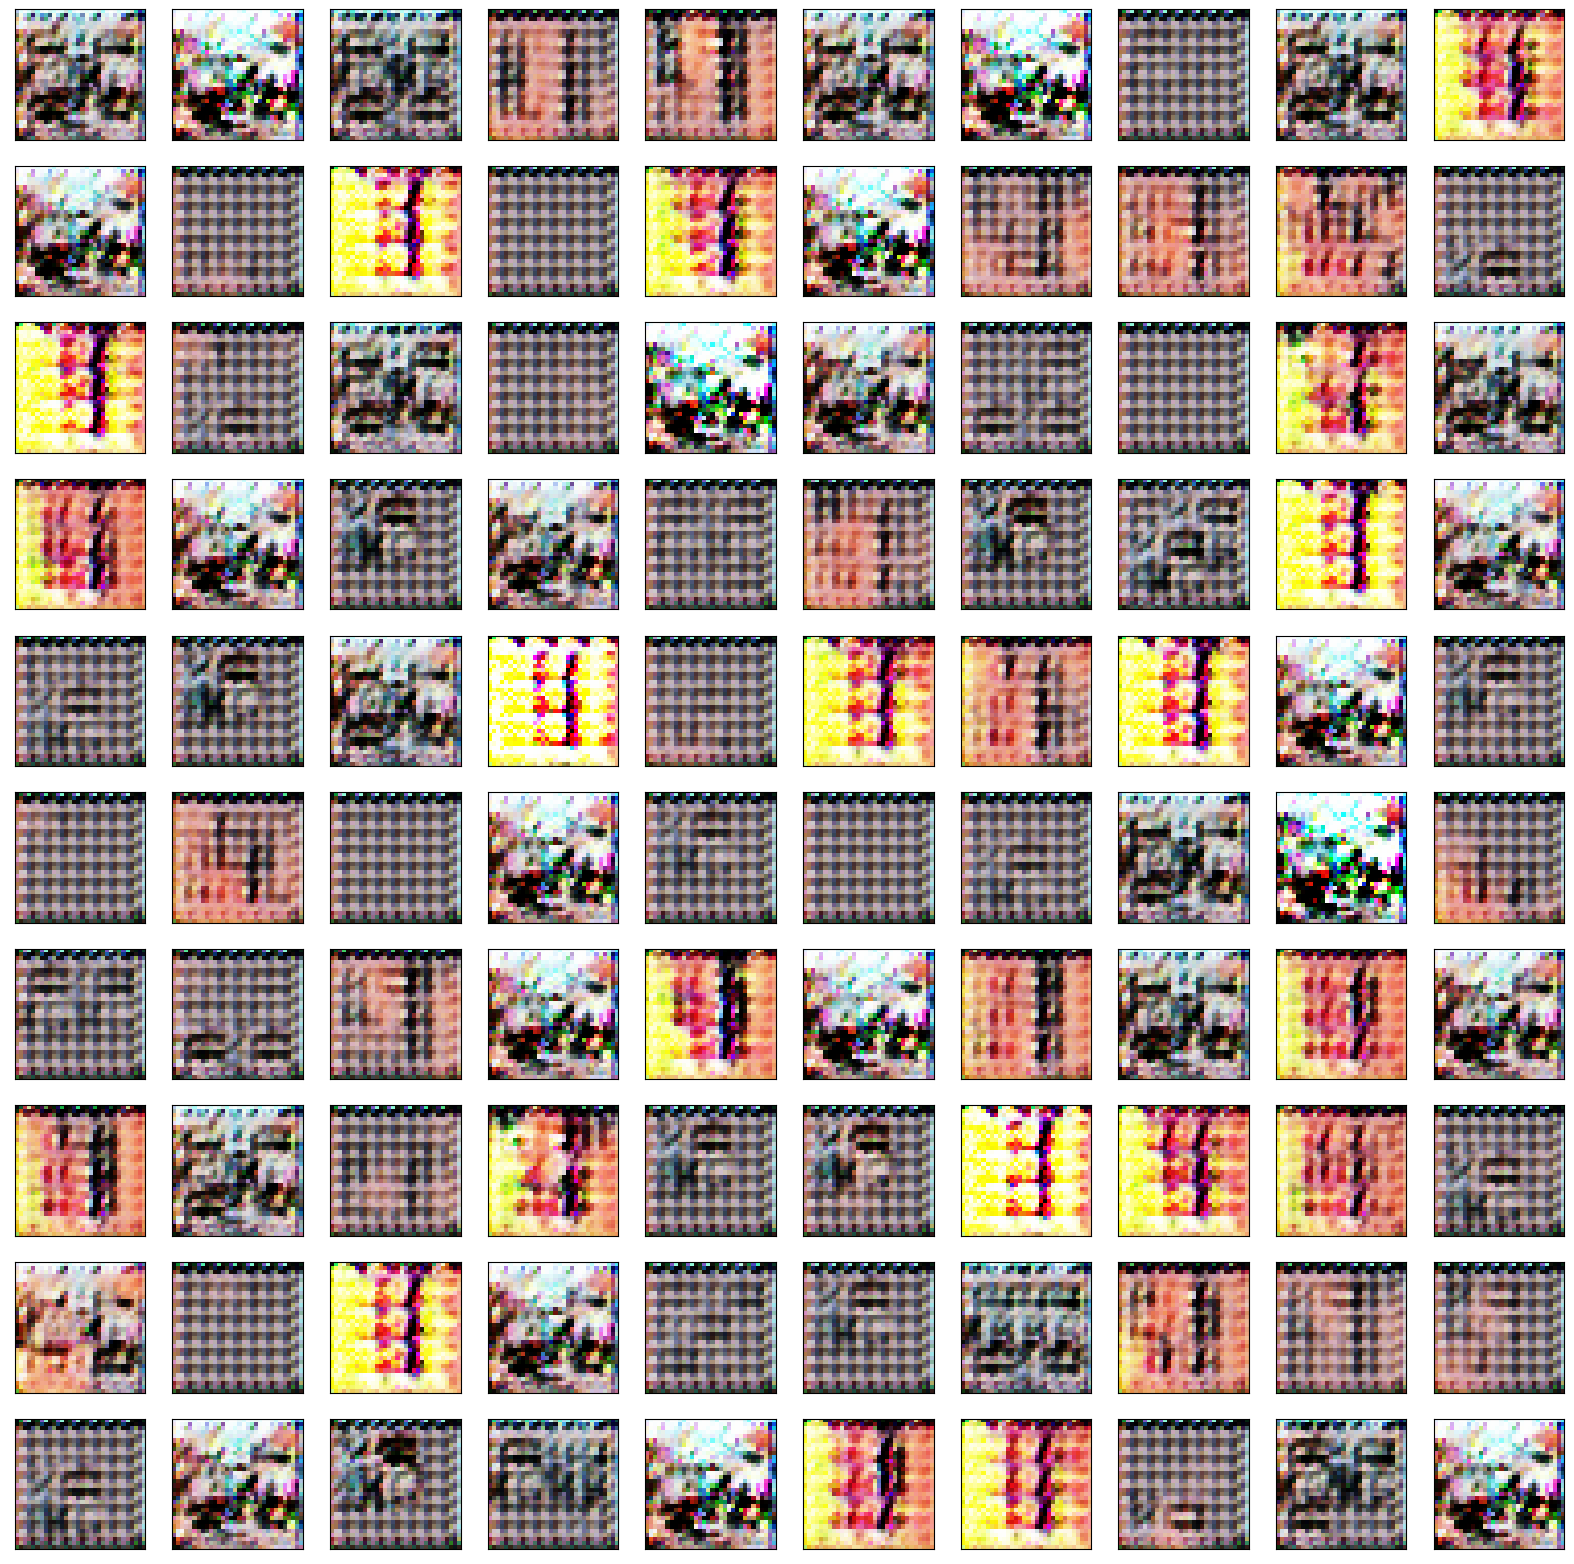

In [87]:
number = 10
plt.figure(figsize=(20, 20))
z = torch.randn(10*number, 256, 1, 1).to(torch.device("cuda"))
generated = gan(z)
for i in range(number):
    ax = plt.subplot(10, number, i + 1)
    plt.imshow(generated[i].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + number)
    plt.imshow(generated[i+number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 2*number)
    plt.imshow(generated[i+2*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 3*number)
    plt.imshow(generated[i+3*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 4*number)
    plt.imshow(generated[i+4*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 5*number)
    plt.imshow(generated[i+5*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 6*number)
    plt.imshow(generated[i+6*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 7*number)
    plt.imshow(generated[i+7*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 8*number)
    plt.imshow(generated[i+8*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 9*number)
    plt.imshow(generated[i+9*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Impact LeakyRelu (100 epochs)

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [7]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(3, 64, 4, stride=2, padding=1),           # [batch, 64, 4, 4]
            torch.nn.LeakyReLU(0.2),
            torch.nn.Conv2d(64, 128, 4, stride=2, padding=1),          # [batch, 128, 2, 2]
            torch.nn.BatchNorm2d(128),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Conv2d(128, 256, 4, stride=2, padding=1),          # [batch, 256, 1, 1]
            torch.nn.BatchNorm2d(256),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Conv2d(256, 1, 4, stride=1, padding=0),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        """ Classifie un batch d'images en tant que vraie (1) ou fausse (0)
            Args:
                x (tensor torch, dim(batch_size x 3x32x32)) : batch de bruits initiaux
            Output:
                label (tensor torch, dim(batch_size)) : tensor de labels prédits des images (vraies ou fausses)
        """
        return self.model(x).view(-1, 1)

In [9]:
gan = GAN().to(torch.device("cuda"))
optim_g = torch.optim.Adam(gan.generator.parameters())
optim_d = torch.optim.Adam(gan.discriminator.parameters())
losses_true, losses_fake, losses_generator = gan.train_model(data_train, 100, optim_g, optim_d)

  0%|          | 0/100 [00:00<?, ?it/s]

13:01:28 : Epoch 0 - Loss Discriminator 0.15 - Loss Generator 8.09
13:01:49 : Epoch 1 - Loss Discriminator 0.20 - Loss Generator 7.21
13:02:08 : Epoch 2 - Loss Discriminator 0.17 - Loss Generator 6.91
13:02:28 : Epoch 3 - Loss Discriminator 0.18 - Loss Generator 6.71
13:02:48 : Epoch 4 - Loss Discriminator 0.22 - Loss Generator 6.32
13:03:13 : Epoch 5 - Loss Discriminator 0.23 - Loss Generator 6.21
13:03:31 : Epoch 6 - Loss Discriminator 0.28 - Loss Generator 5.74
13:03:48 : Epoch 7 - Loss Discriminator 0.22 - Loss Generator 5.69
13:04:05 : Epoch 8 - Loss Discriminator 0.21 - Loss Generator 6.15
13:04:22 : Epoch 9 - Loss Discriminator 0.25 - Loss Generator 5.66
13:04:40 : Epoch 10 - Loss Discriminator 0.30 - Loss Generator 5.54
13:04:57 : Epoch 11 - Loss Discriminator 0.29 - Loss Generator 4.96
13:05:14 : Epoch 12 - Loss Discriminator 0.33 - Loss Generator 4.93
13:05:31 : Epoch 13 - Loss Discriminator 0.32 - Loss Generator 4.73
13:05:49 : Epoch 14 - Loss Discriminator 0.29 - Loss Gener

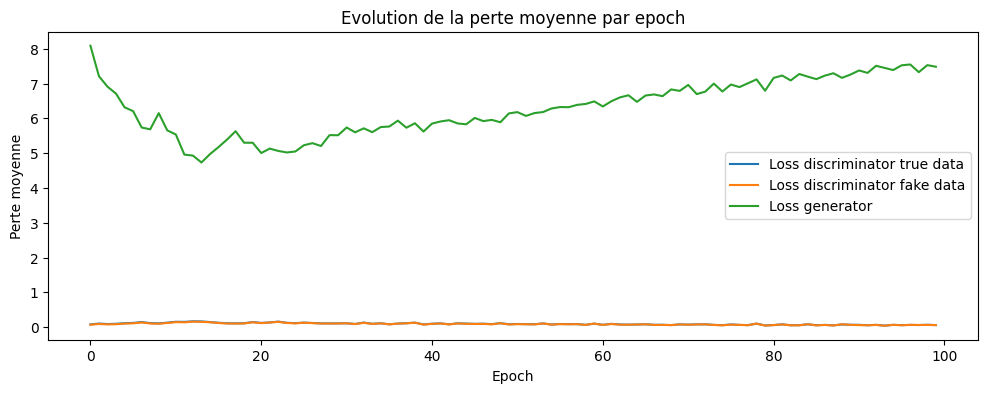

In [10]:
plt.figure(figsize=(12, 4))
ab = np.arange(100)
plt.plot(ab, losses_true, label="Loss discriminator true data")
plt.plot(ab, losses_fake, label="Loss discriminator fake data")
plt.plot(ab, losses_generator, label="Loss generator")
plt.xlabel("Epoch")
plt.ylabel("Perte moyenne")
plt.title("Evolution de la perte moyenne par epoch")
plt.legend()
plt.show()

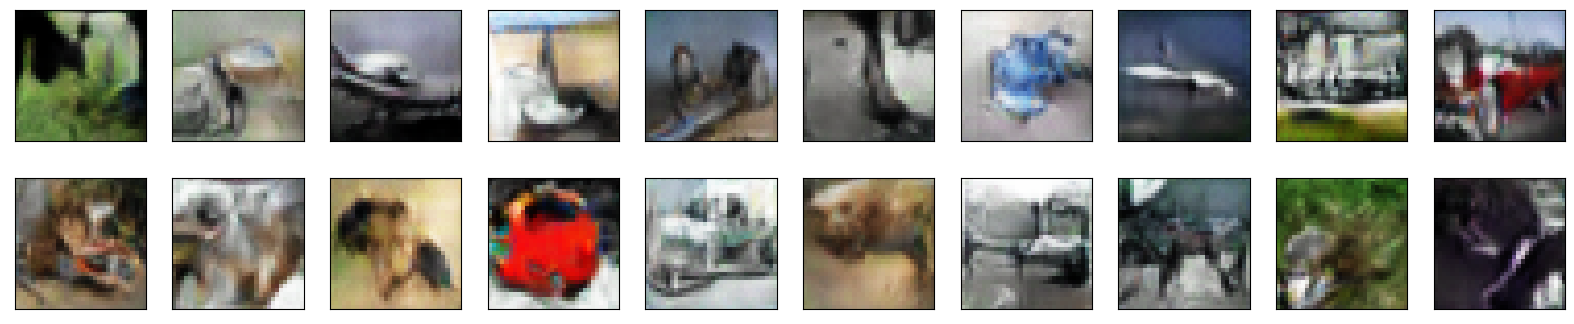

In [11]:
number = 10
plt.figure(figsize=(20, 4))
z = torch.randn(2*number, 256, 1, 1).to(torch.device("cuda"))
generated = gan(z)
for i in range(number):
    ax = plt.subplot(2, number, i + 1)
    plt.imshow(generated[i].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, number, i + 1 + number)
    plt.imshow(generated[i+number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

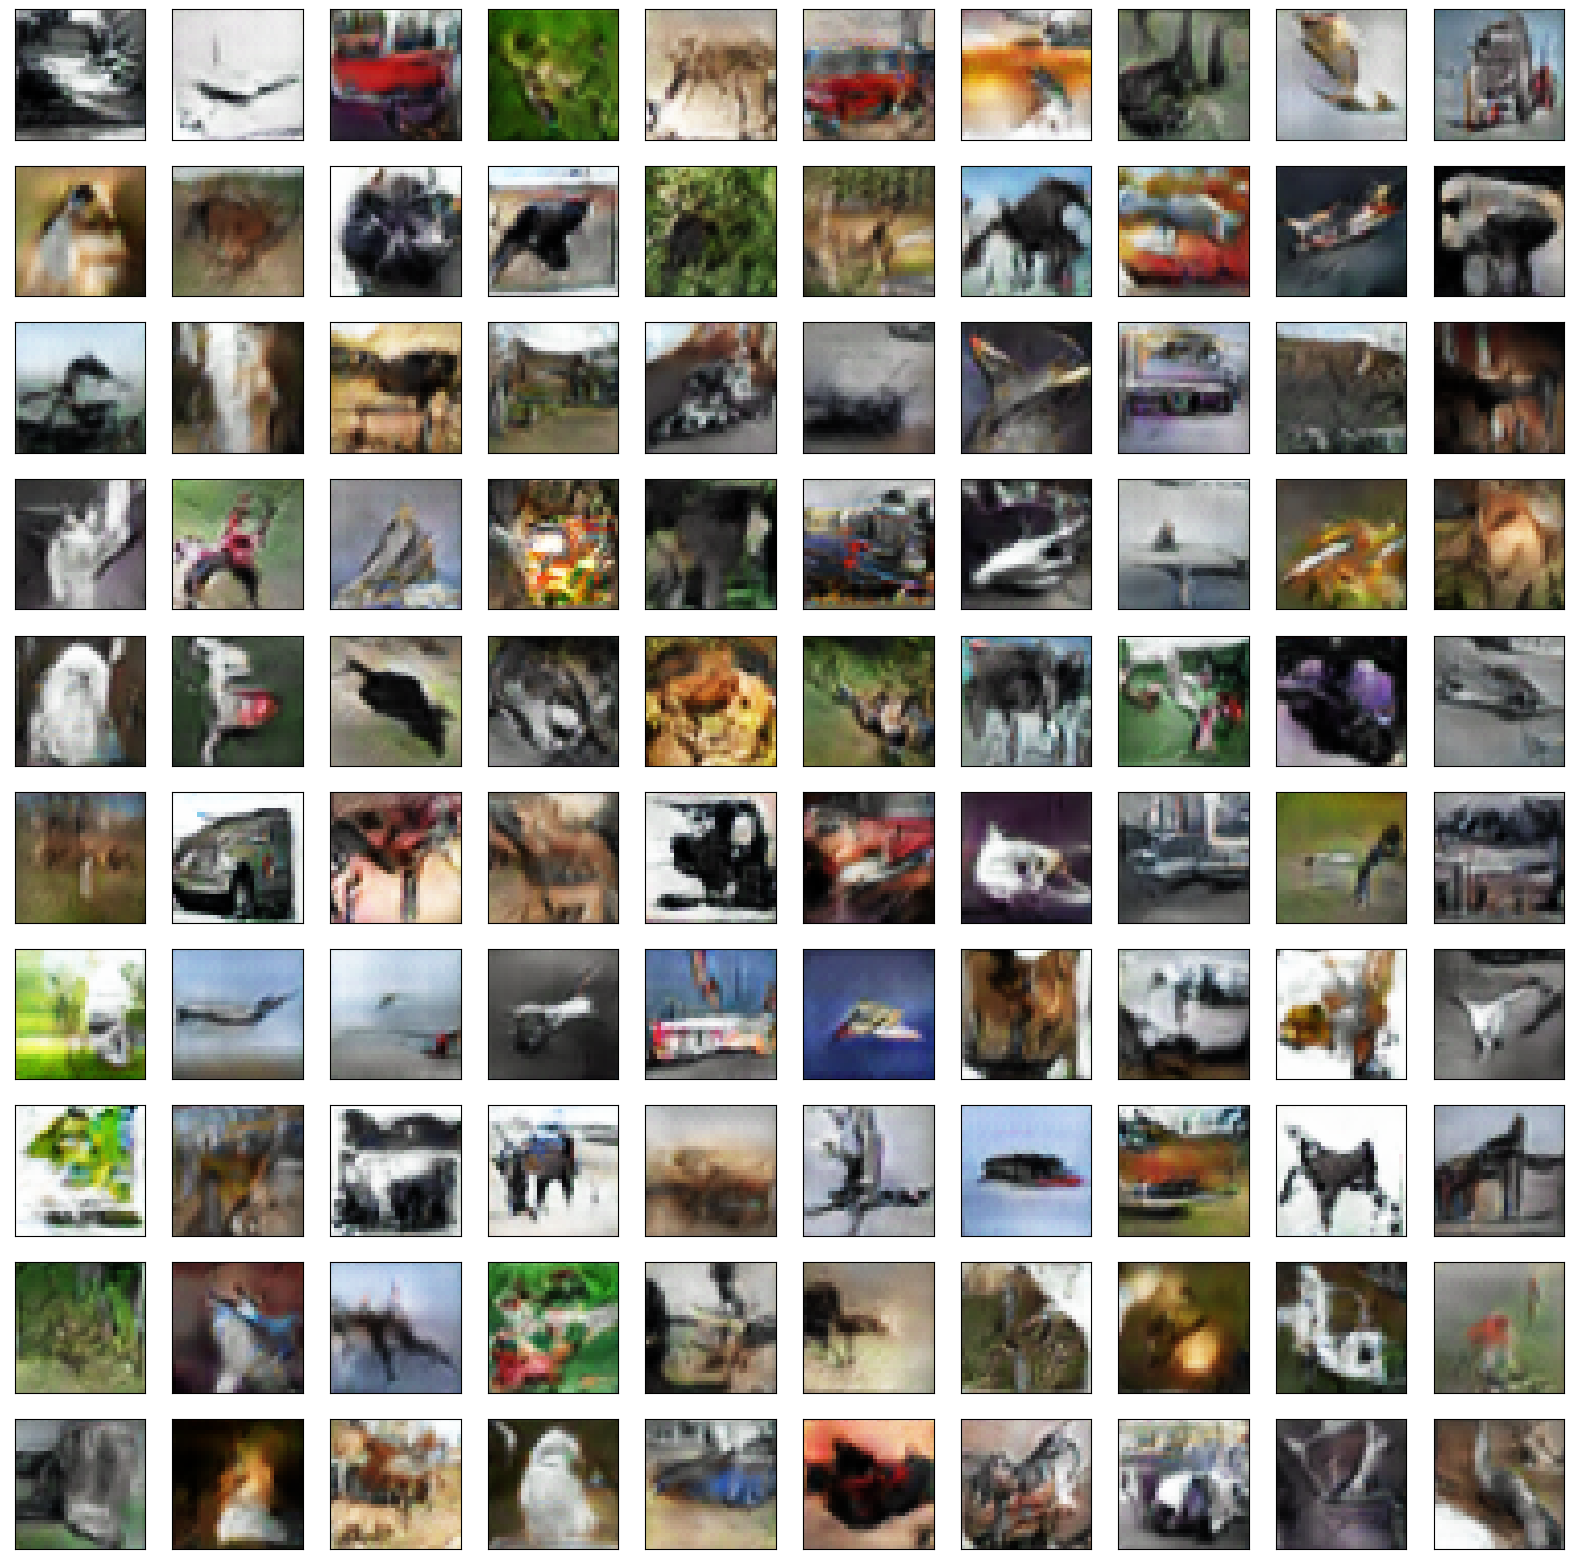

In [12]:
number = 10
plt.figure(figsize=(20, 20))
z = torch.randn(10*number, 256, 1, 1).to(torch.device("cuda"))
generated = gan(z)
for i in range(number):
    ax = plt.subplot(10, number, i + 1)
    plt.imshow(generated[i].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + number)
    plt.imshow(generated[i+number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 2*number)
    plt.imshow(generated[i+2*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 3*number)
    plt.imshow(generated[i+3*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 4*number)
    plt.imshow(generated[i+4*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 5*number)
    plt.imshow(generated[i+5*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 6*number)
    plt.imshow(generated[i+6*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 7*number)
    plt.imshow(generated[i+7*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 8*number)
    plt.imshow(generated[i+8*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 9*number)
    plt.imshow(generated[i+9*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### 25 epochs

In [13]:
gan = GAN().to(torch.device("cuda"))
optim_g = torch.optim.Adam(gan.generator.parameters())
optim_d = torch.optim.Adam(gan.discriminator.parameters())
losses_true, losses_fake, losses_generator = gan.train_model(data_train, 25, optim_g, optim_d)

  0%|          | 0/25 [00:00<?, ?it/s]

13:48:37 : Epoch 0 - Loss Discriminator 0.14 - Loss Generator 7.34
13:48:55 : Epoch 1 - Loss Discriminator 0.15 - Loss Generator 6.97
13:49:12 : Epoch 2 - Loss Discriminator 0.21 - Loss Generator 6.97
13:49:30 : Epoch 3 - Loss Discriminator 0.18 - Loss Generator 7.00
13:49:47 : Epoch 4 - Loss Discriminator 0.21 - Loss Generator 6.75
13:50:04 : Epoch 5 - Loss Discriminator 0.27 - Loss Generator 6.07
13:50:22 : Epoch 6 - Loss Discriminator 0.30 - Loss Generator 5.61
13:50:39 : Epoch 7 - Loss Discriminator 0.28 - Loss Generator 5.42
13:50:57 : Epoch 8 - Loss Discriminator 0.24 - Loss Generator 5.79
13:51:14 : Epoch 9 - Loss Discriminator 0.28 - Loss Generator 5.40
13:51:32 : Epoch 10 - Loss Discriminator 0.26 - Loss Generator 5.32
13:51:49 : Epoch 11 - Loss Discriminator 0.27 - Loss Generator 5.27
13:52:06 : Epoch 12 - Loss Discriminator 0.27 - Loss Generator 5.27
13:52:24 : Epoch 13 - Loss Discriminator 0.33 - Loss Generator 4.97
13:52:41 : Epoch 14 - Loss Discriminator 0.28 - Loss Gener

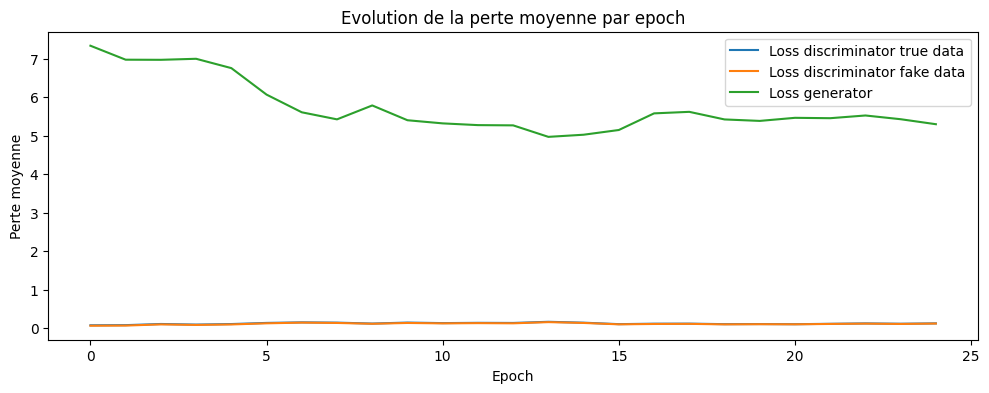

In [14]:
plt.figure(figsize=(12, 4))
ab = np.arange(25)
plt.plot(ab, losses_true, label="Loss discriminator true data")
plt.plot(ab, losses_fake, label="Loss discriminator fake data")
plt.plot(ab, losses_generator, label="Loss generator")
plt.xlabel("Epoch")
plt.ylabel("Perte moyenne")
plt.title("Evolution de la perte moyenne par epoch")
plt.legend()
plt.show()

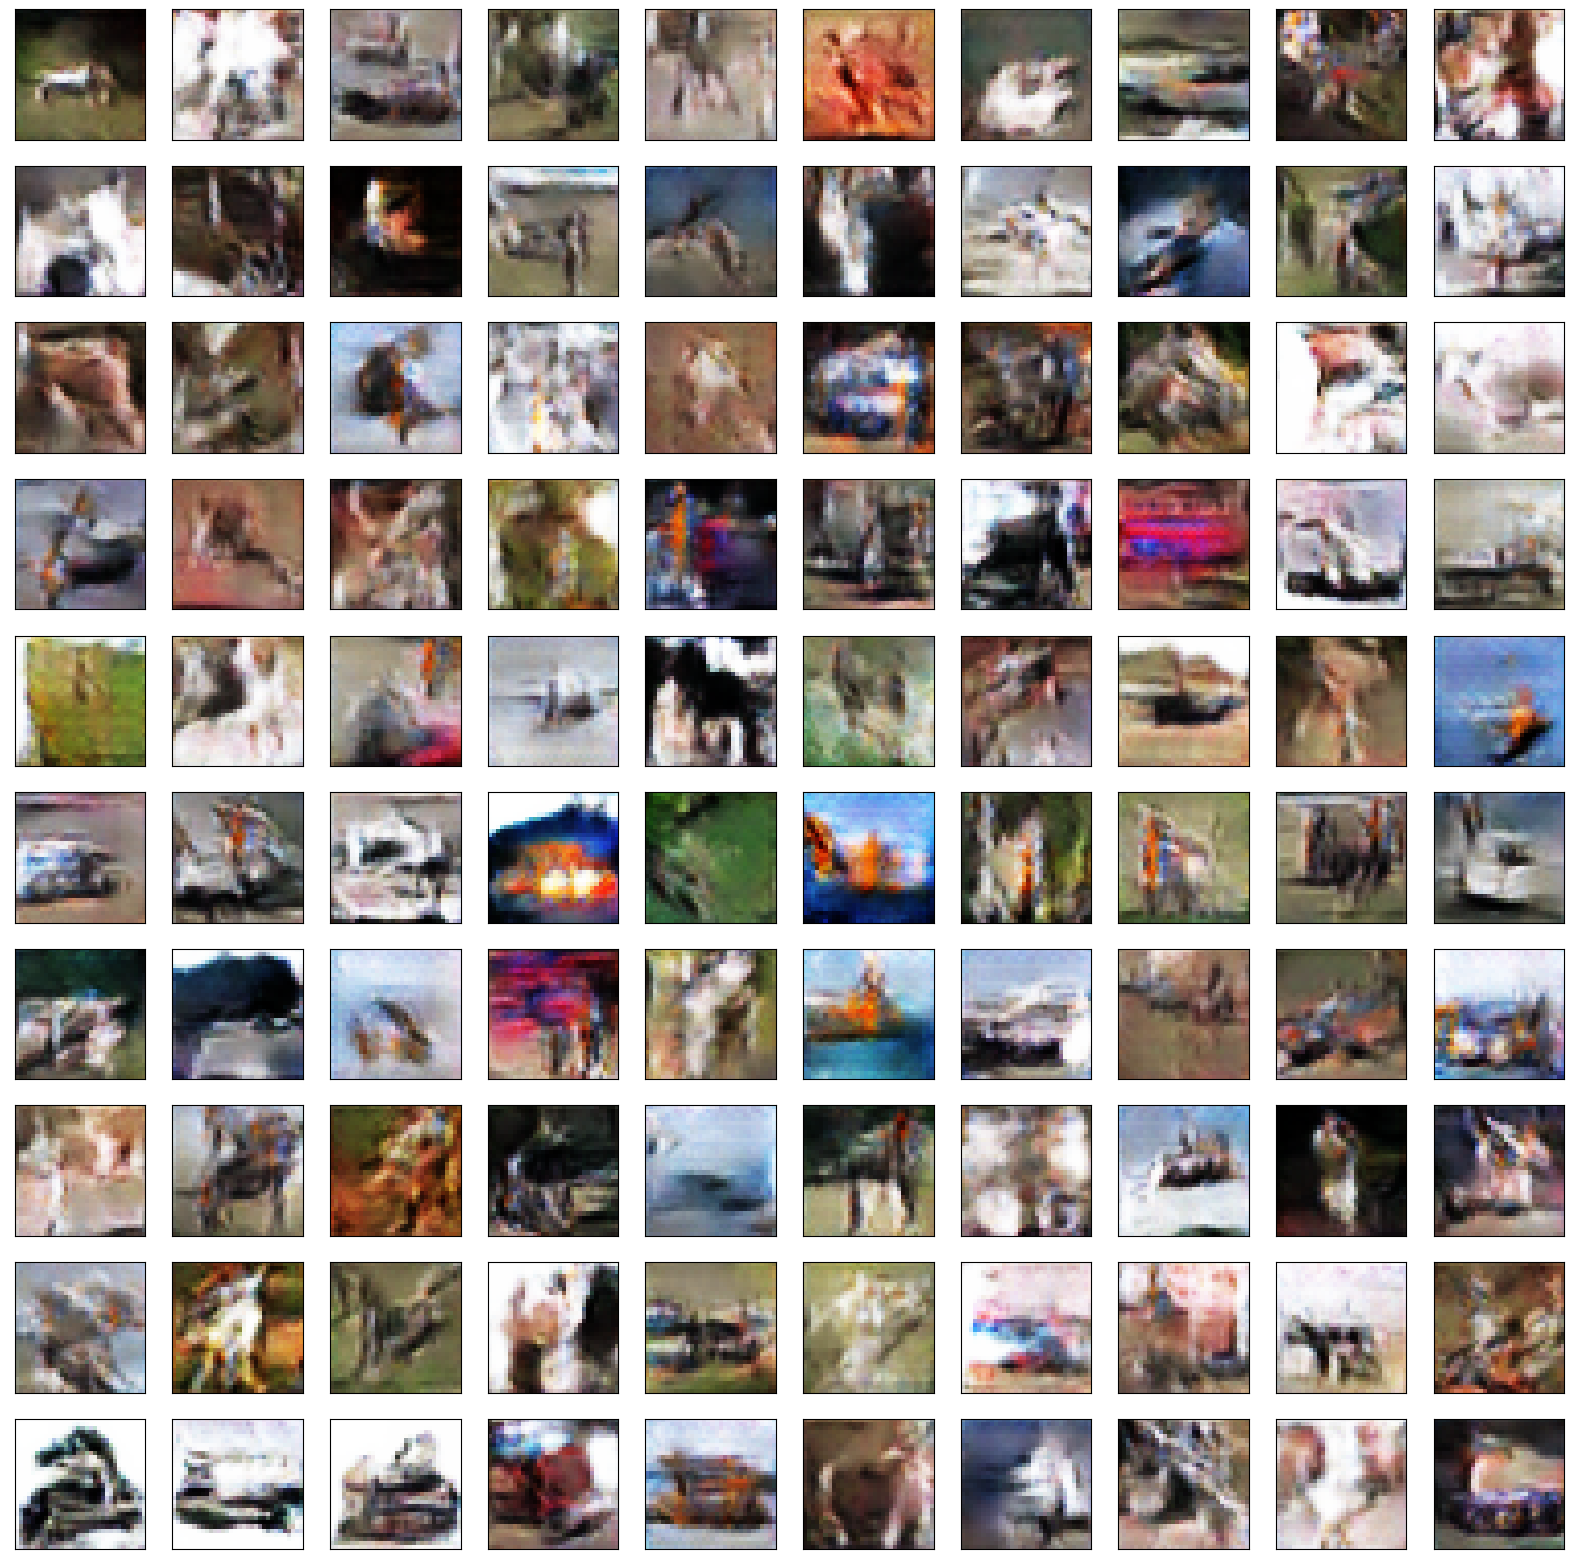

In [15]:
number = 10
plt.figure(figsize=(20, 20))
z = torch.randn(10*number, 256, 1, 1).to(torch.device("cuda"))
generated = gan(z)
for i in range(number):
    ax = plt.subplot(10, number, i + 1)
    plt.imshow(generated[i].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + number)
    plt.imshow(generated[i+number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 2*number)
    plt.imshow(generated[i+2*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 3*number)
    plt.imshow(generated[i+3*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 4*number)
    plt.imshow(generated[i+4*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 5*number)
    plt.imshow(generated[i+5*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 6*number)
    plt.imshow(generated[i+6*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 7*number)
    plt.imshow(generated[i+7*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 8*number)
    plt.imshow(generated[i+8*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(10, number, i + 1 + 9*number)
    plt.imshow(generated[i+9*number].view(3, 32, 32).permute(1,2,0).cpu().detach().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()